<a href="https://colab.research.google.com/github/alecseiterr/pleural_effusion/blob/main/Dmitrii_Utkin/effusion_ct_ranges.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


[Information on SimpleITK image drections](https://simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1DICOMOrientImageFilter.html)

In [14]:
import SimpleITK as sitk
import numpy as np
import pandas as pd
import glob
import ast
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d

In [15]:
labels_path = '/Users/dutking/LOCAL/AI_uni/radlogix/dataset/labels' #/LUNG1-001/LUNG1-001_effusion_first_reviewer.nii.gz
lungs_path = '/Users/dutking/LOCAL/AI_uni/radlogix/dataset/lungs_labels' #/LUNG1-001/LUNG1-001_thor_cav_primary_reviewer.nii.gz
features_path = '/Users/dutking/LOCAL/AI_uni/radlogix/dataset/features' #/LUNG1-001/09-18-2008-StudyID-NA-69331/0.000000-NA-82046

In [16]:
WINDOW_MIN = 0
WINDOW_MAX = 50

In [17]:
df = pd.read_csv("./_docs/clean_cropped_df.csv", index_col="PatientID")
df.drop(df[df['Effusion.Event'] == 0].index, inplace=True)
df.head(2)

Feature.Slices  Effusion.Event  Previously.Excluded  Valid.Feature  \
PatientID                                                                       
LUNG1-001           134.0             1.0                  0.0            1.0   
LUNG1-002           111.0             1.0                  0.0            1.0   

           Valid.Label Clean.Reviews  
PatientID                             
LUNG1-001          1.0           [1]  
LUNG1-002          1.0        [2, 3]

In [18]:
def get_dicom_folder(id):
    for root, _, files in os.walk(f"{features_path}/{id}", topdown=False):
        if files[0].endswith('.dcm'):
            return root

In [19]:
def get_dicom_array(id):
    dicom_folder = get_dicom_folder(id)
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(dicom_folder)
    reader.SetFileNames(dicom_names)
    image = reader.Execute()
    image = sitk.DICOMOrient(image, 'LPS')
    image_array = sitk.GetArrayFromImage(image)
    return image_array

def get_efusion_array(id, df):
    file_index = ast.literal_eval(df.loc[id,'Clean.Reviews'])[0] - 1
    file = glob.glob(f"{labels_path}/{id}/*.gz")[file_index]
    image = sitk.ReadImage(file)
    image = sitk.DICOMOrient(image, 'LPS')
    image_array = sitk.GetArrayFromImage(image)
    return image_array

def get_lungs_array(id):
    file = glob.glob(f"{lungs_path}/{id}/*.gz")[0]
    image = sitk.ReadImage(file, imageIO="NiftiImageIO")
    image = sitk.DICOMOrient(image, 'LPS')
    image_array = sitk.GetArrayFromImage(image)
    return image_array

In [20]:
def collect_intersection_data(id, df):
    feature_arr = get_dicom_array(id)
    label_arr = get_nifti_array(id, df)
    intersection_array = feature_arr[label_arr.astype(dtype=bool)]
    i_unique, i_counts = np.unique(intersection_array, return_counts=True)

    return i_unique, i_counts

In [21]:
def get_windowed_data(data):
    uniques, counts = data
    indices = np.nonzero((uniques>=WINDOW_MIN) & (uniques<=WINDOW_MAX))[0]
    return uniques[indices], counts[indices]

In [22]:
def plot_data(title, data):
    uniques, counts = get_windowed_data(data)

    most_frequent_value_index = np.argmax(counts)
    most_frequent_value_count = np.max(counts)
    most_frequent_value = uniques[most_frequent_value_index]

    fig, ax = plt.subplots(figsize=(20,10))
    ax.set_title(f"Plot for {title}. Most frequent value - {most_frequent_value} appears {most_frequent_value_count} times.")
    ax.plot(uniques, counts)

    ax.axvline(WINDOW_MIN)
    ax.axvline(WINDOW_MAX)
    ax.axvline(most_frequent_value)
    plt.show()

In [23]:
def analyze_data(df):
    for id in df.index:
        effusion_intersection = collect_intersection_data(id, df)
        plot_data(id, effusion_intersection)

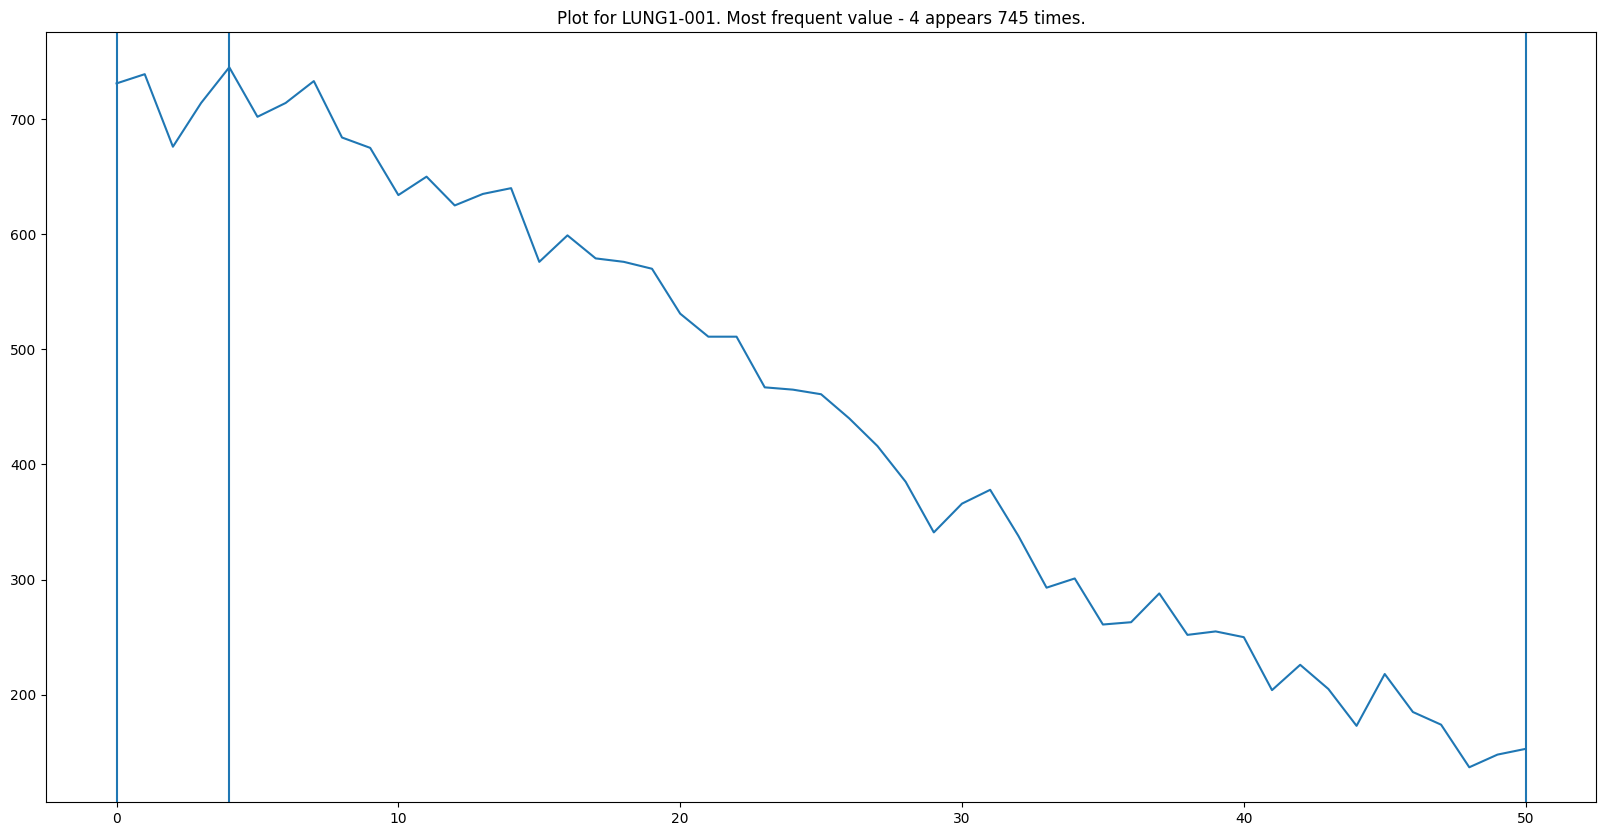

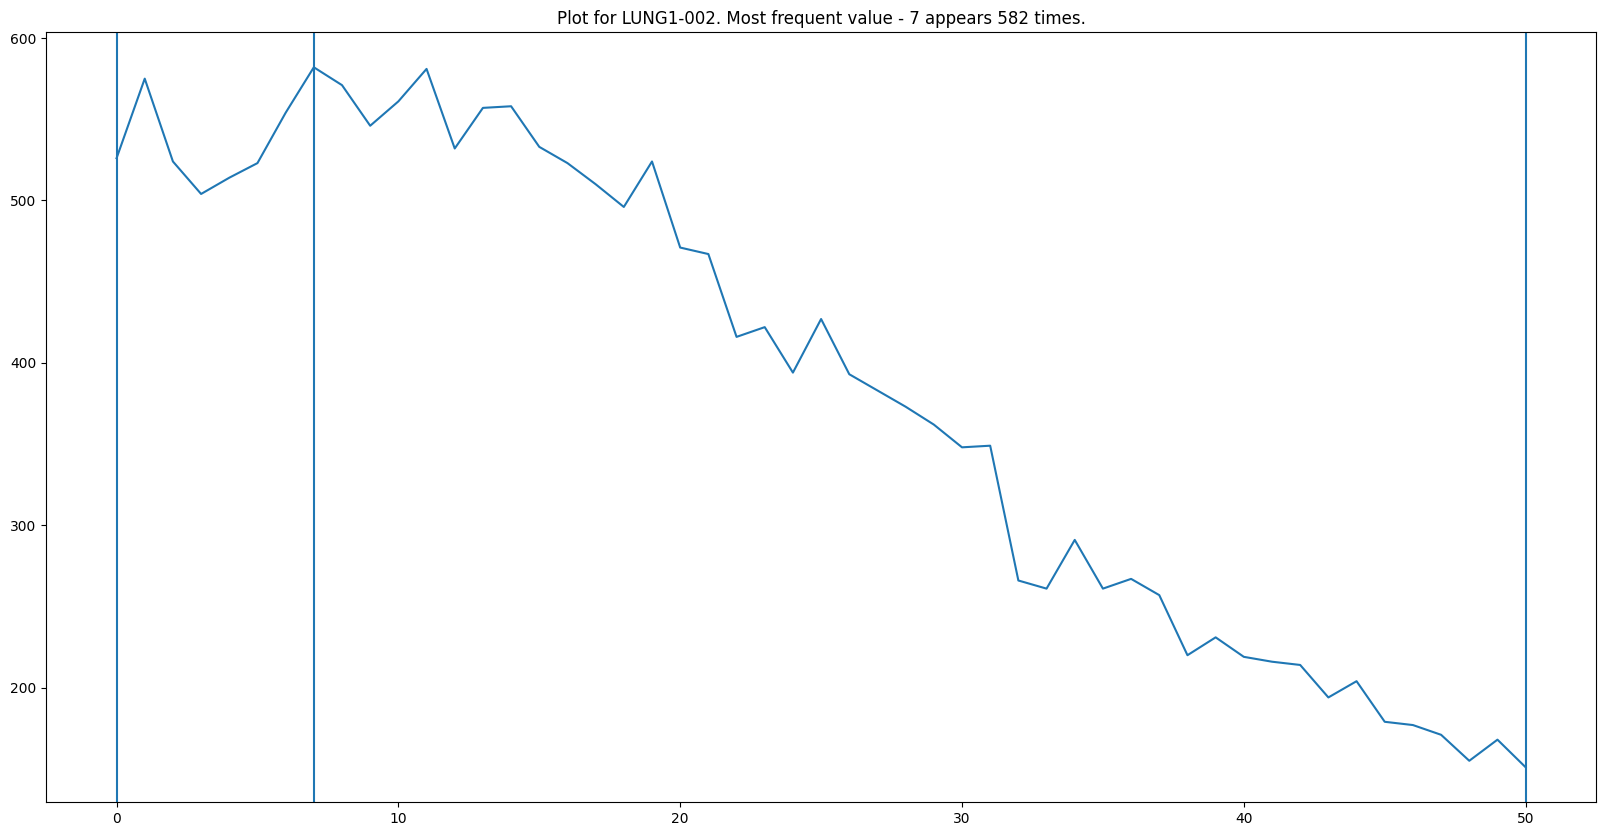

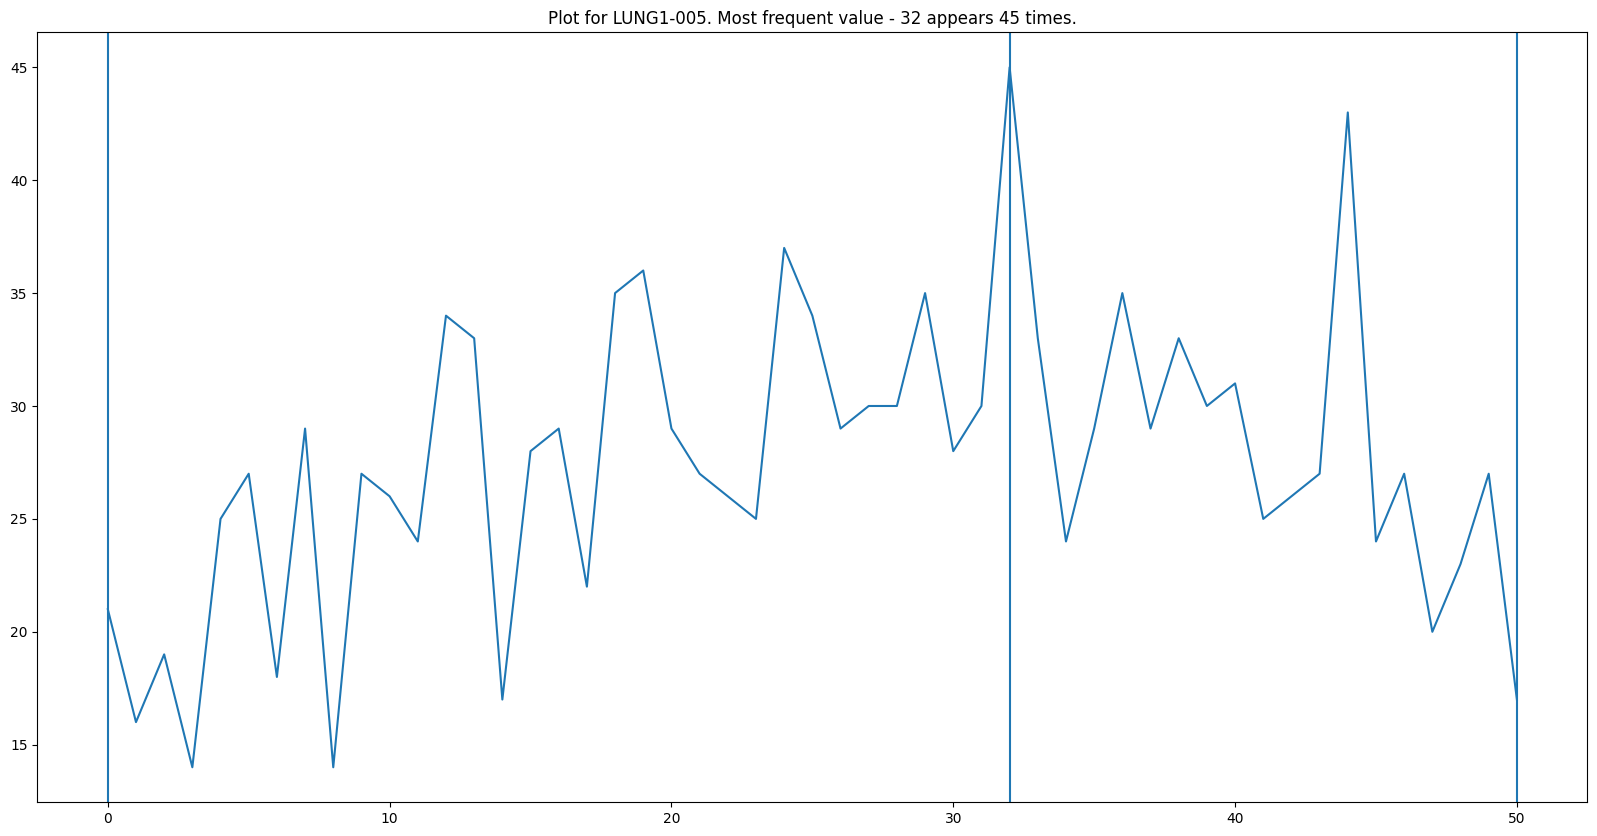

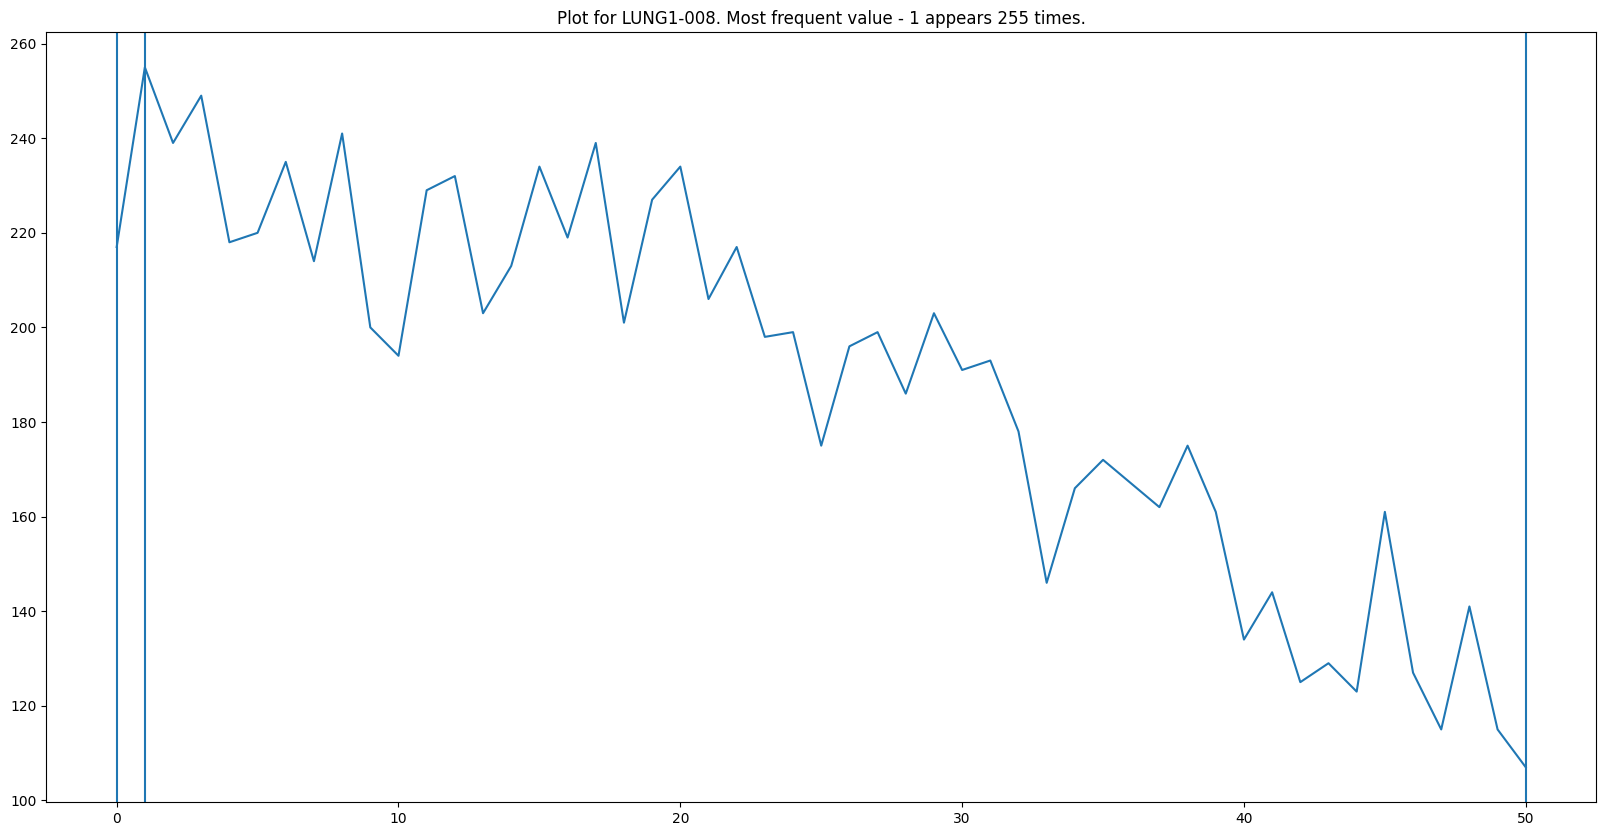

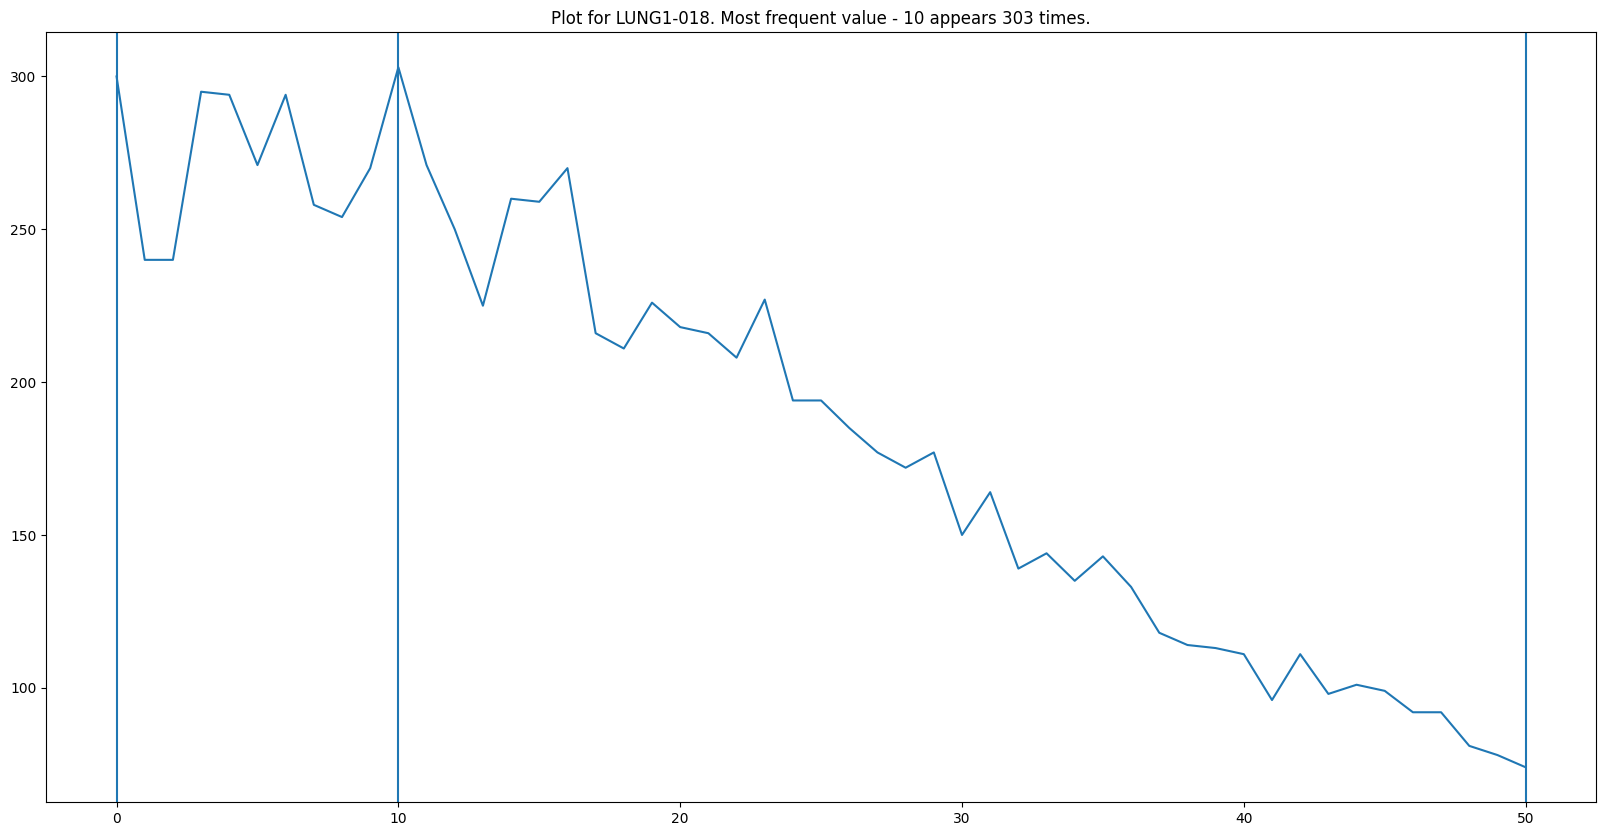

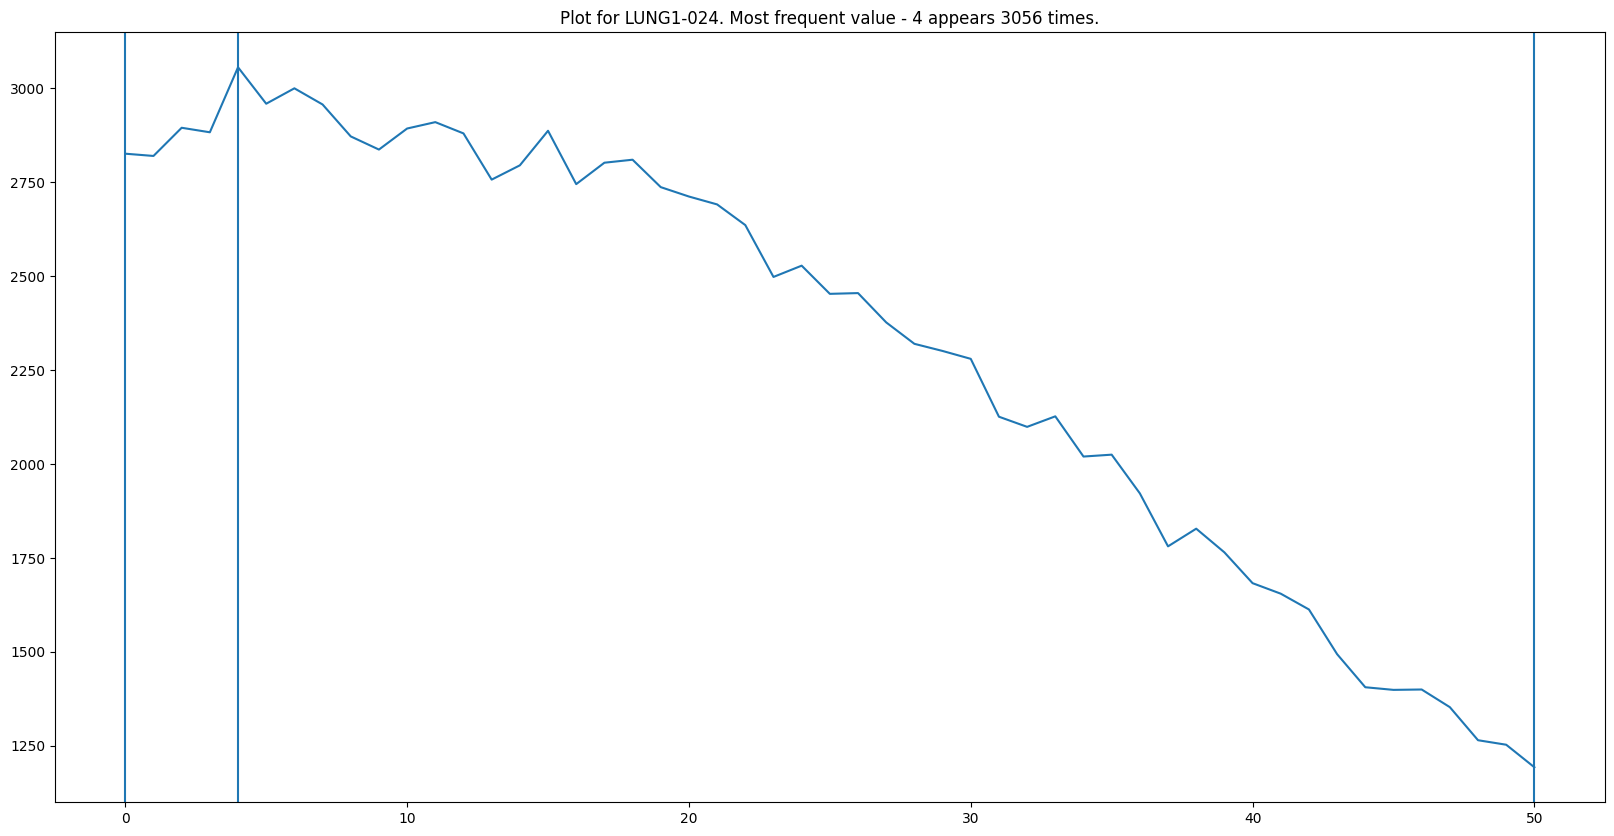

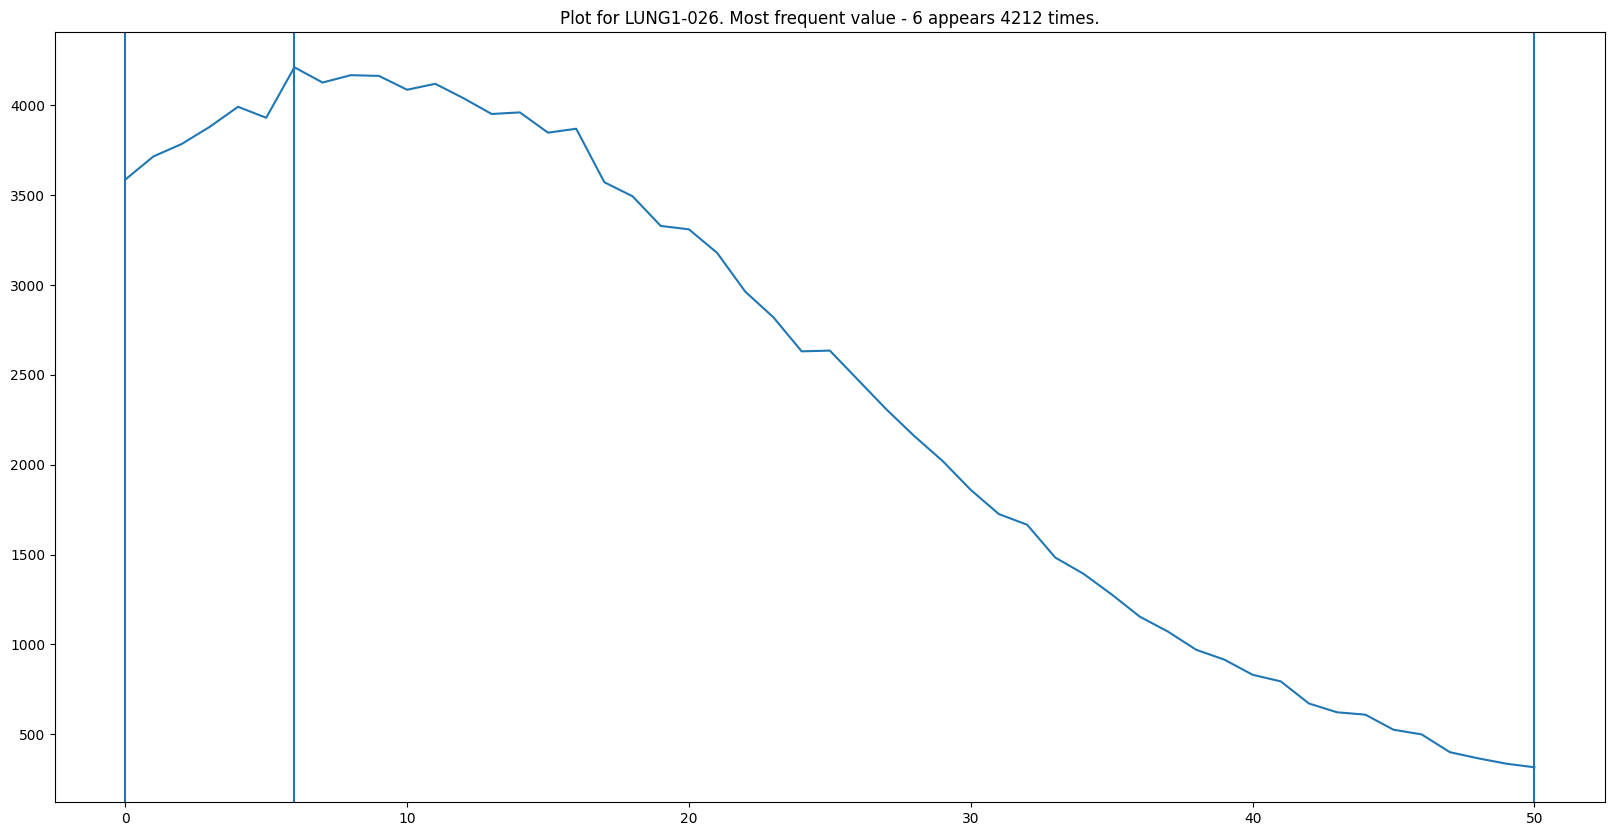

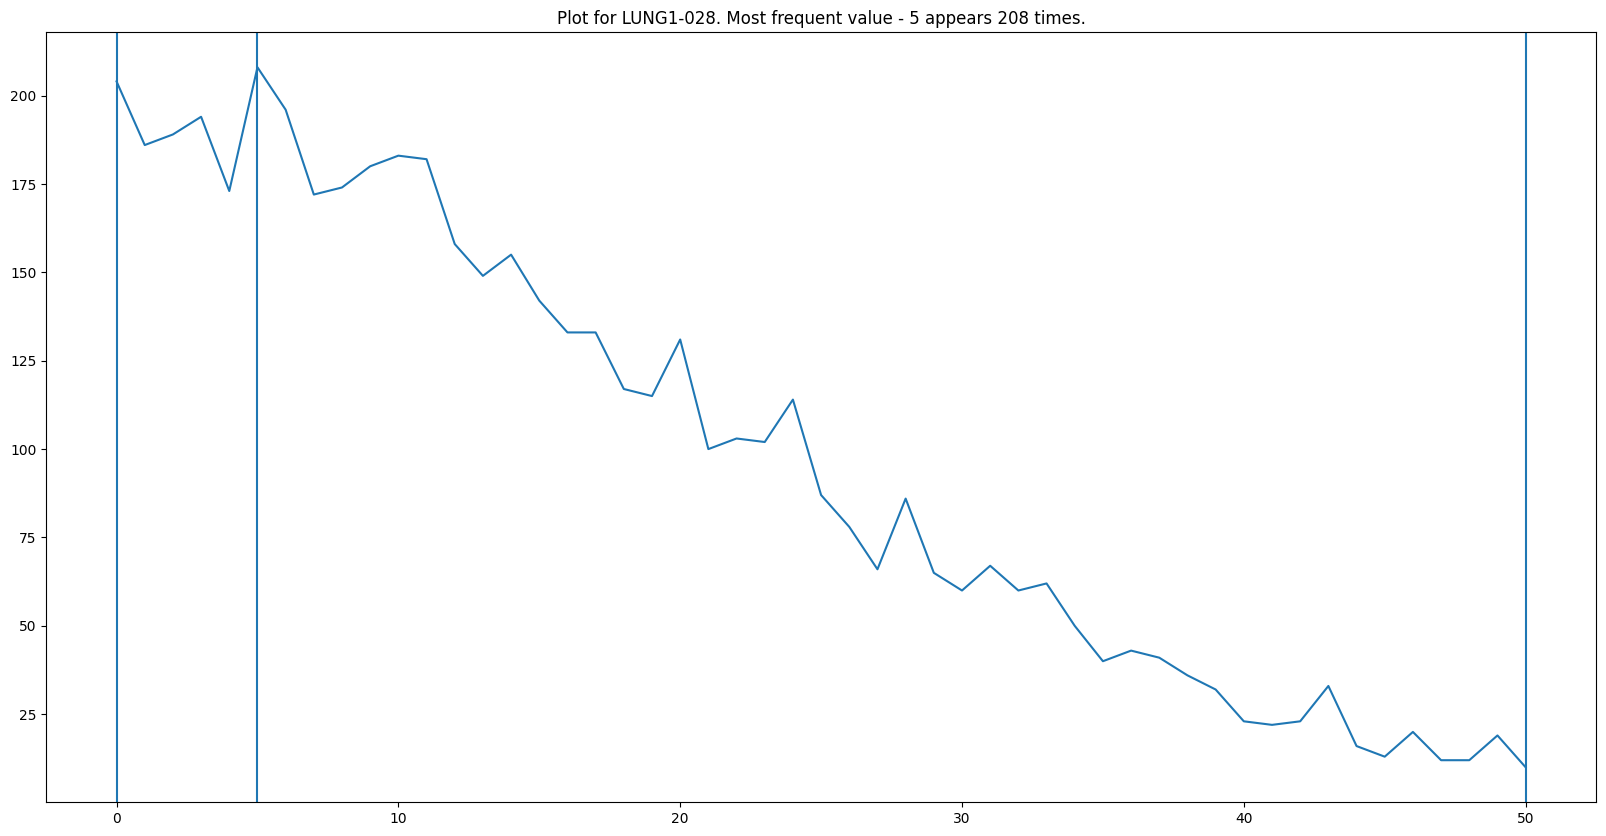

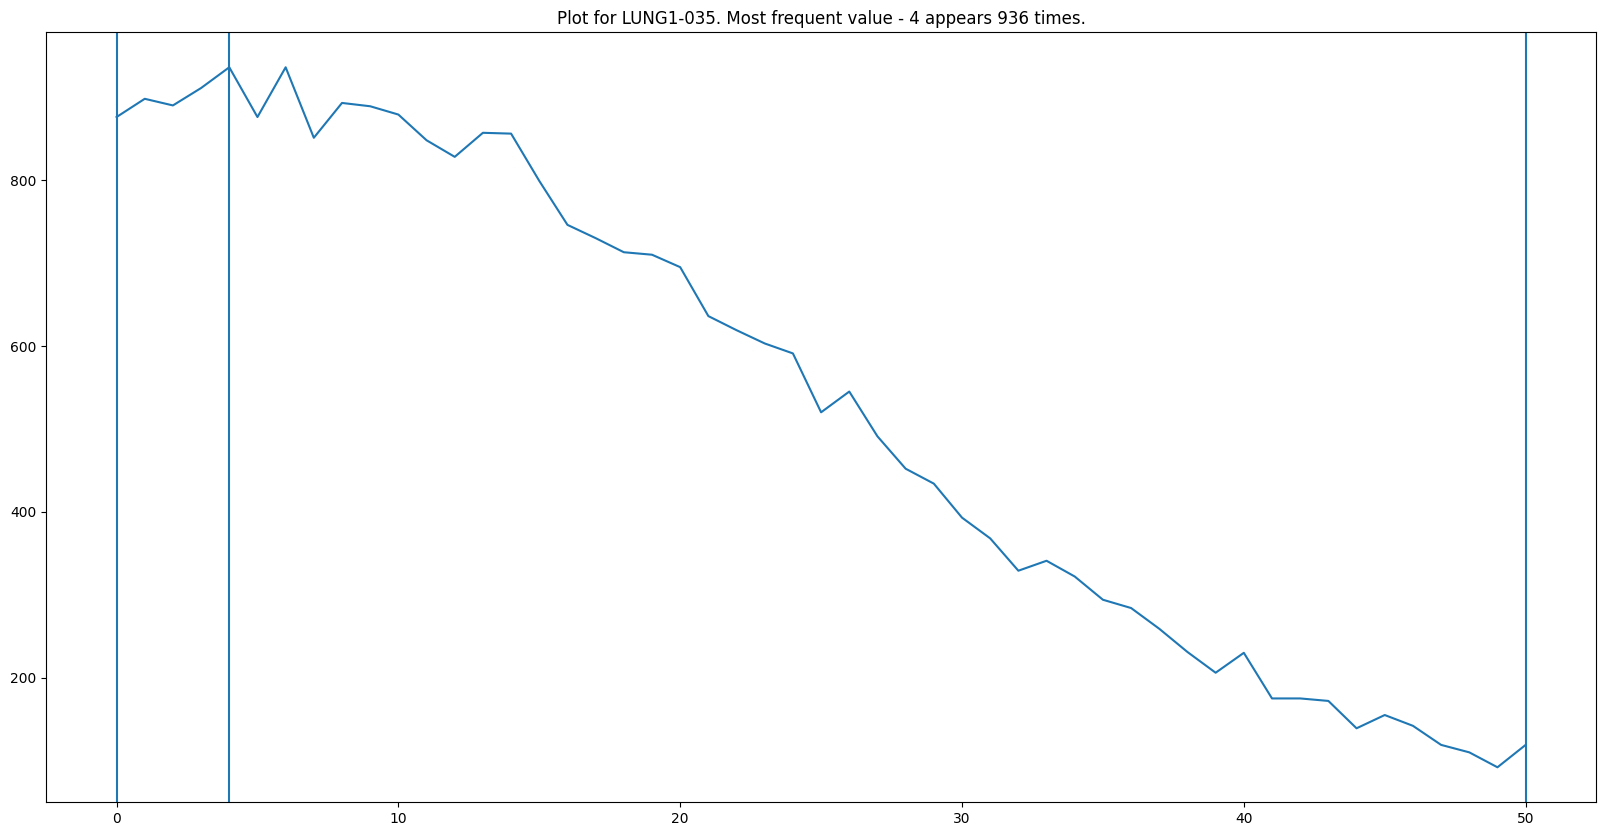

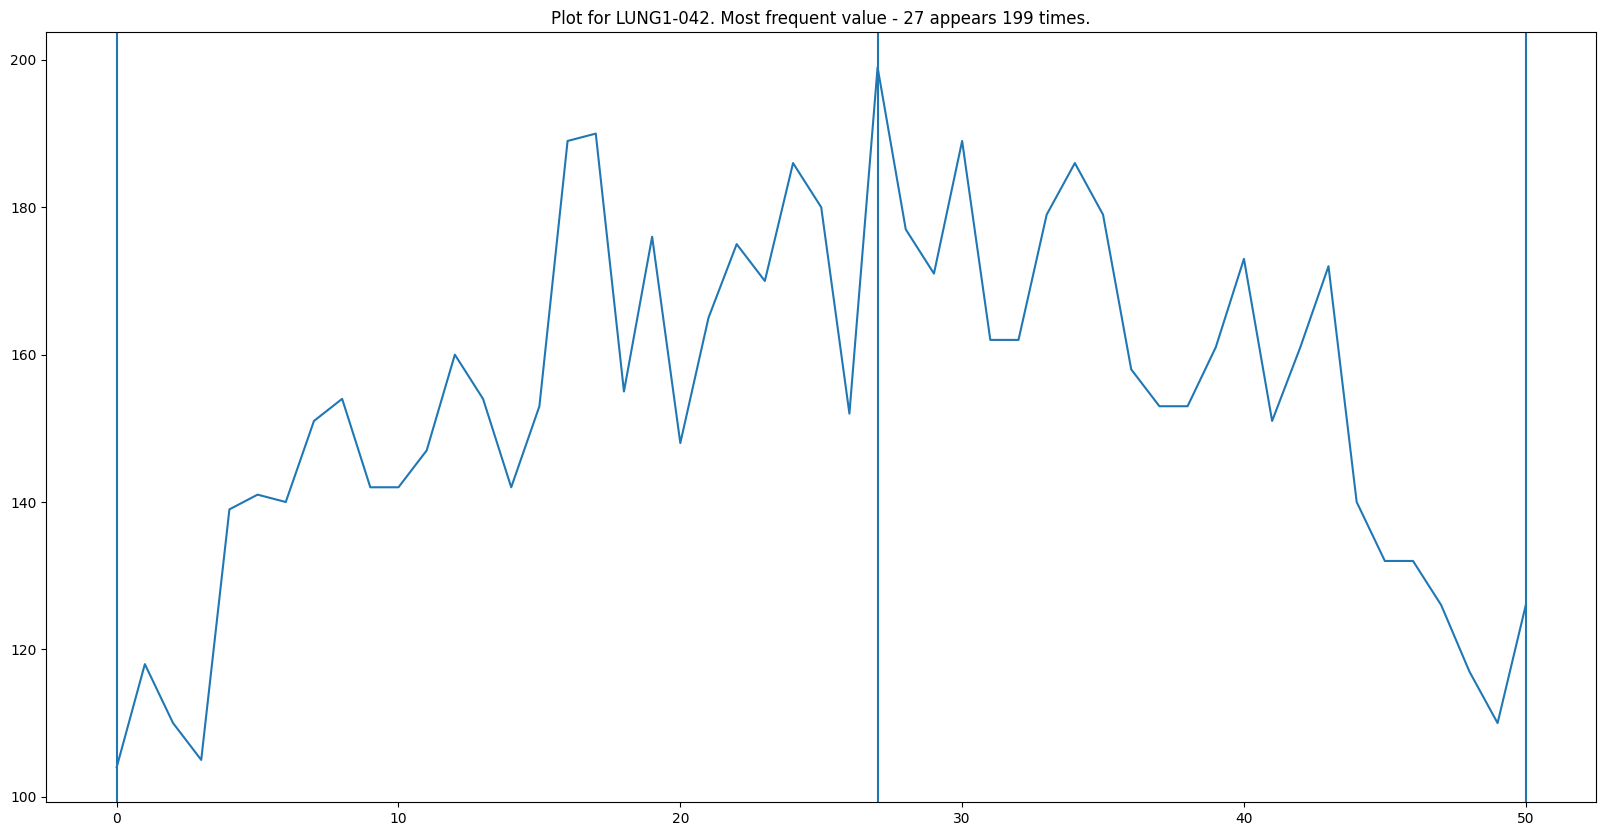

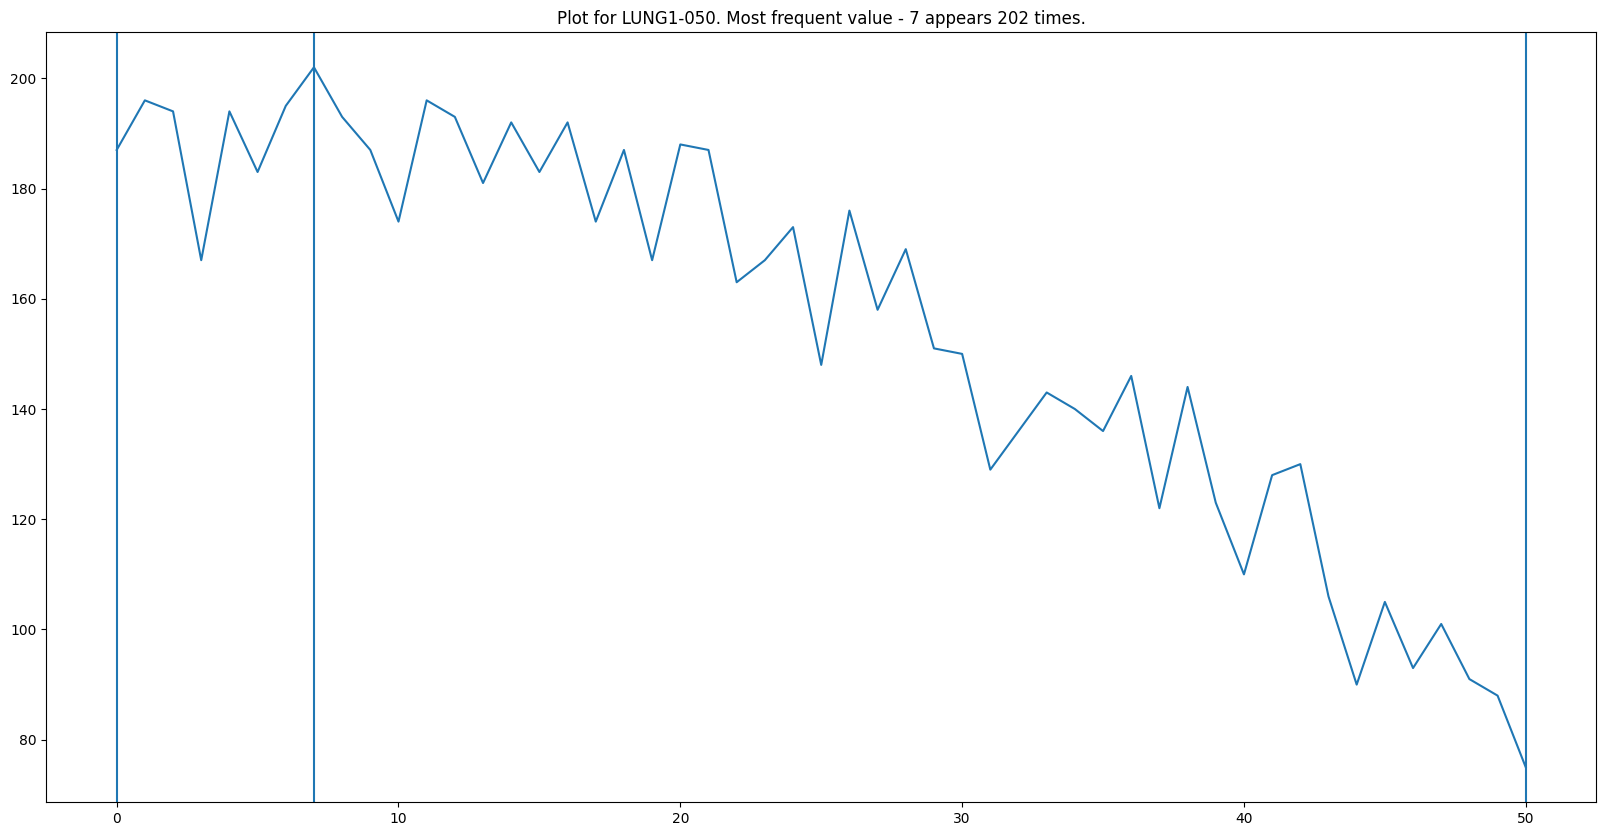

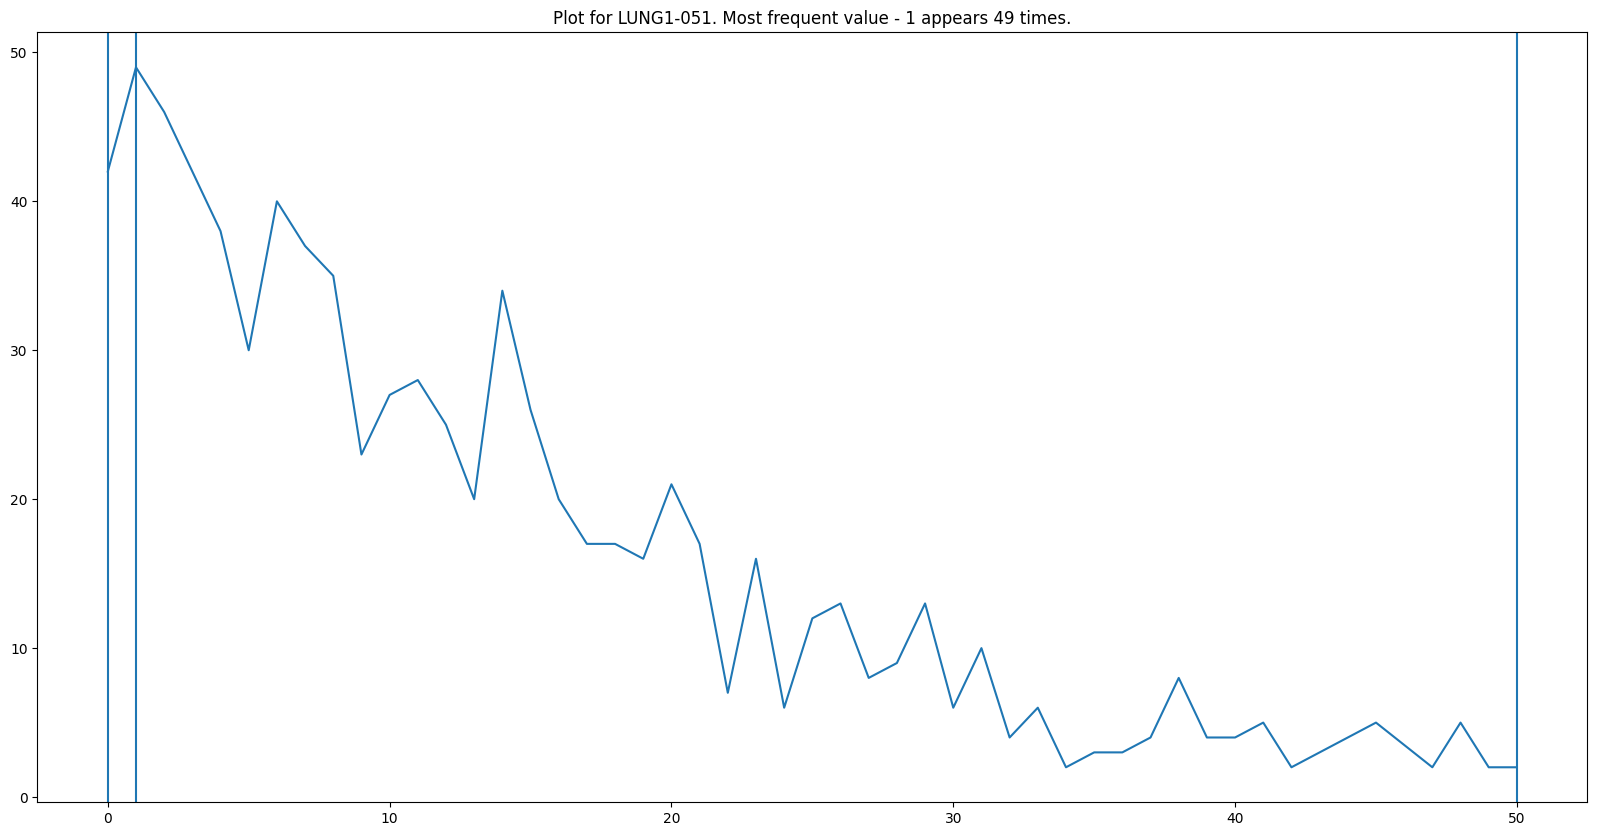

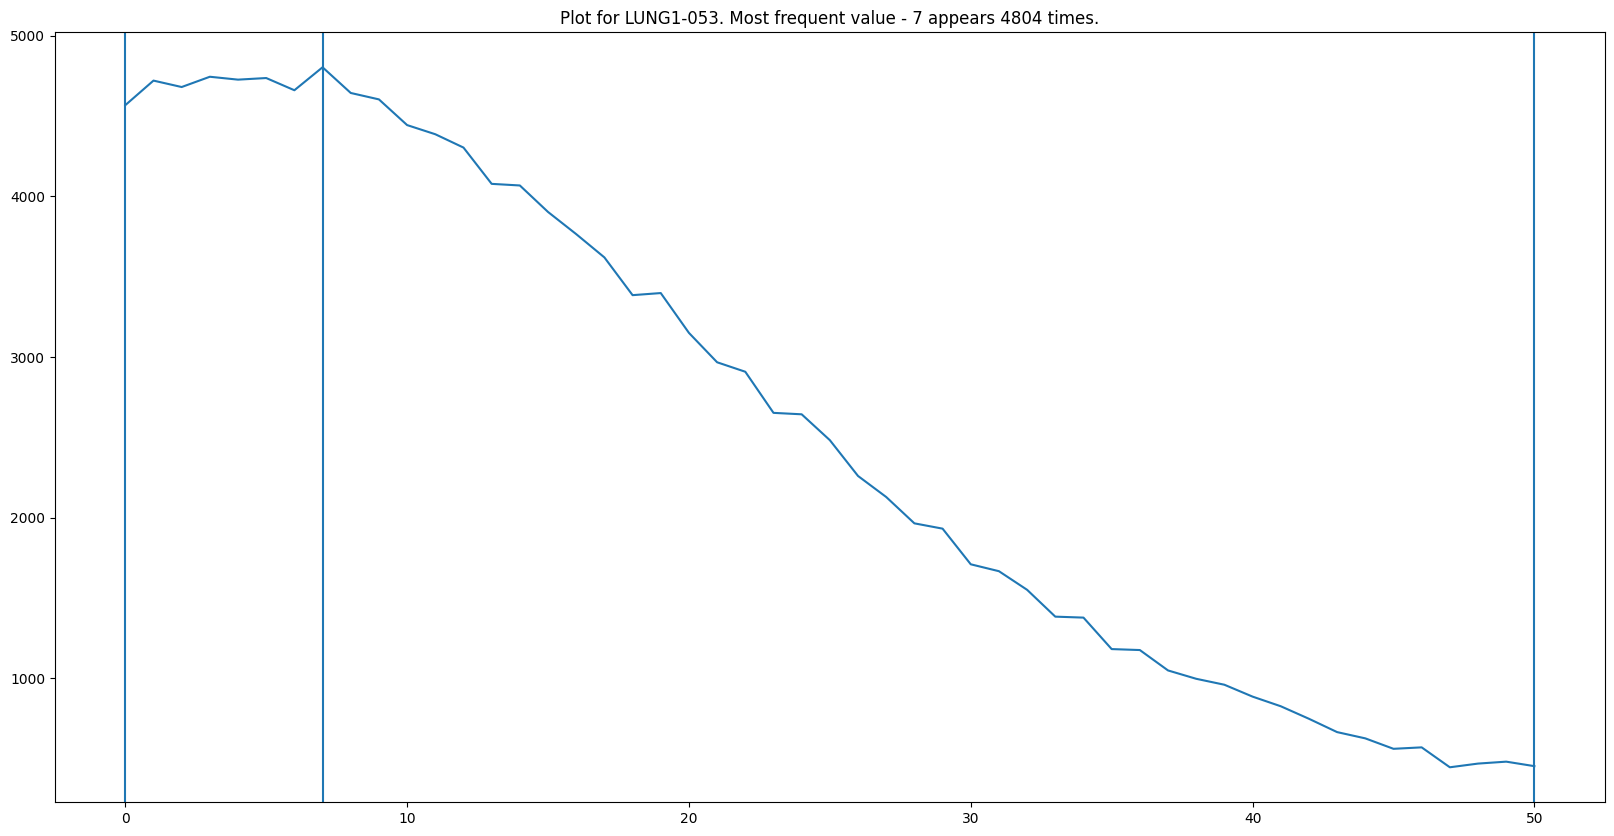

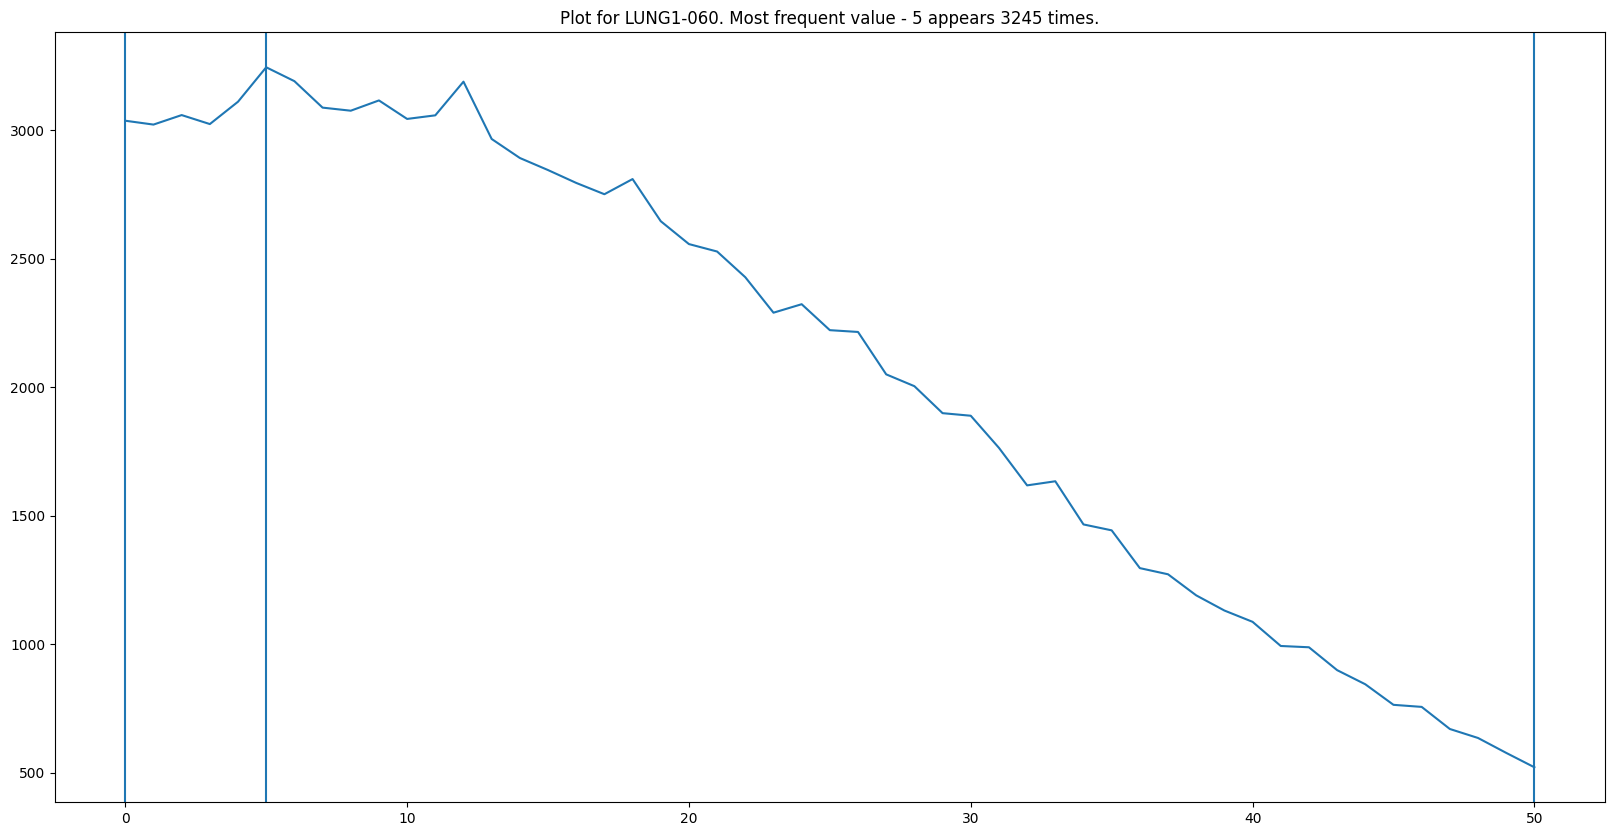

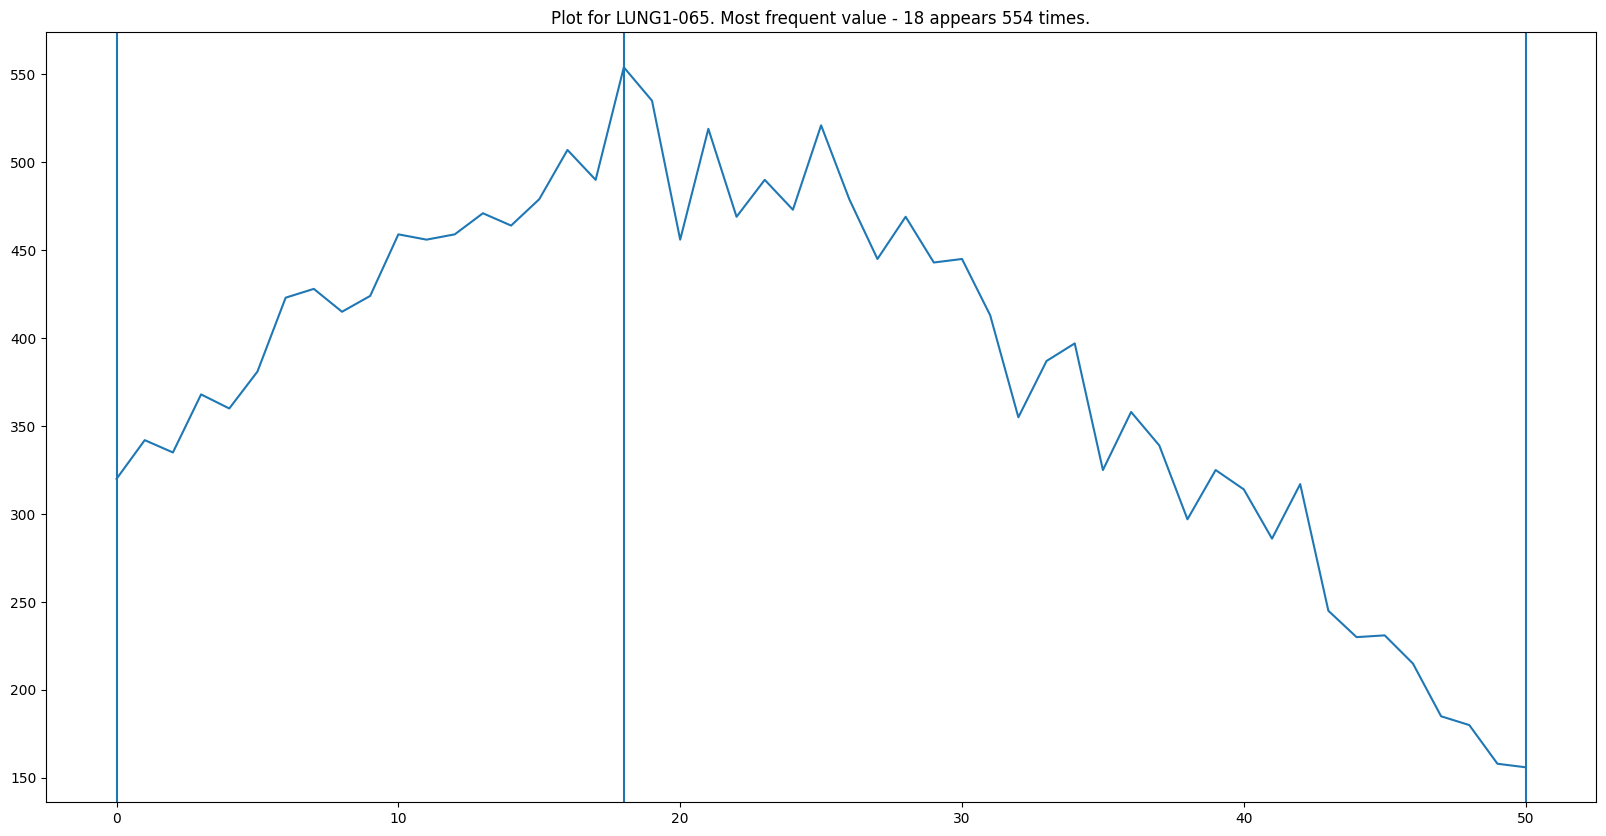

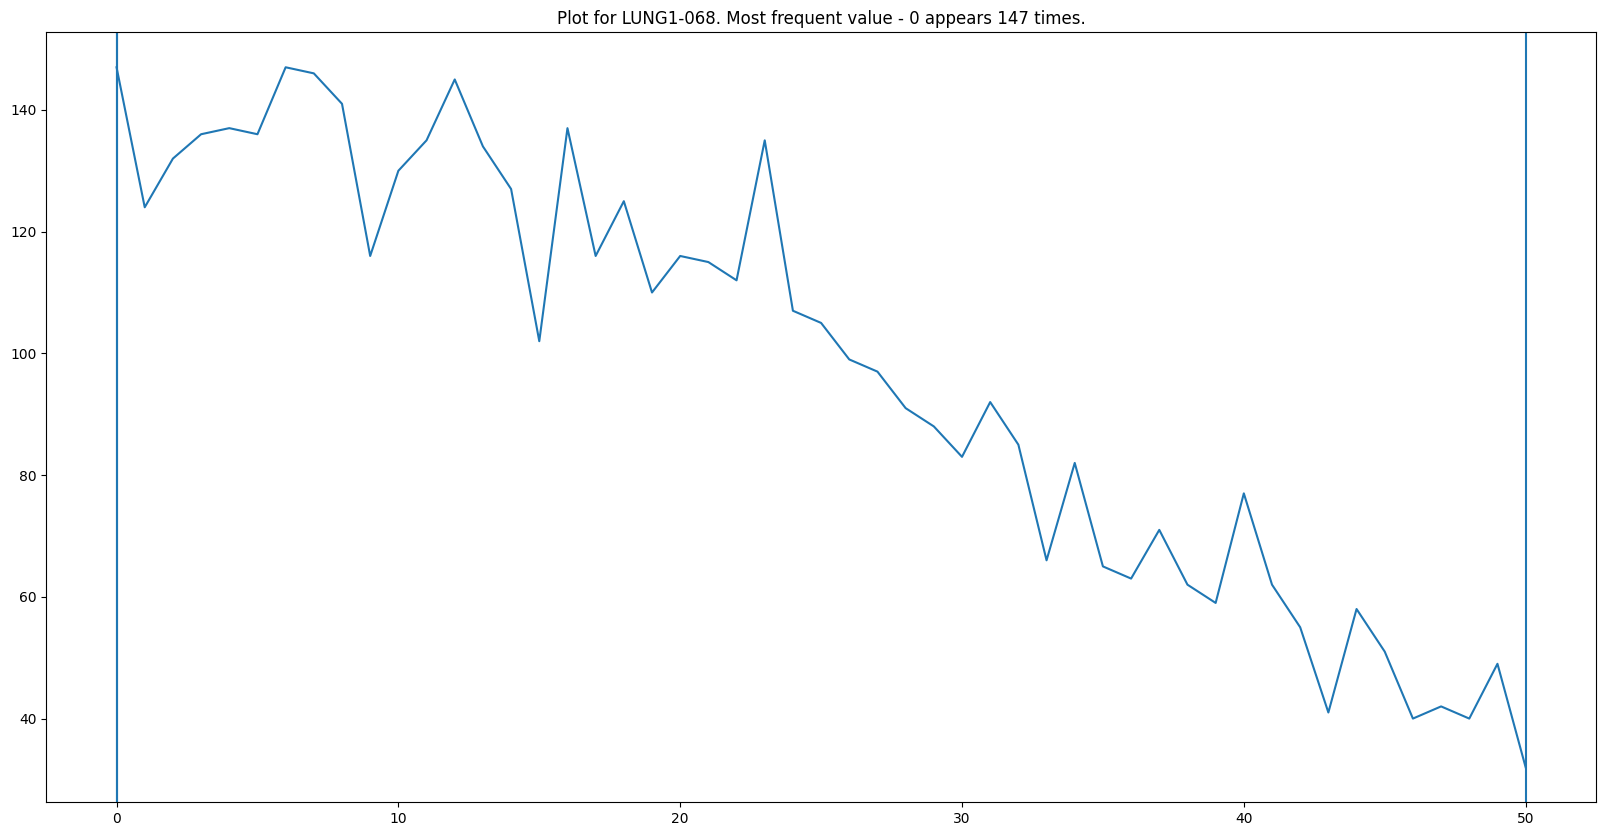

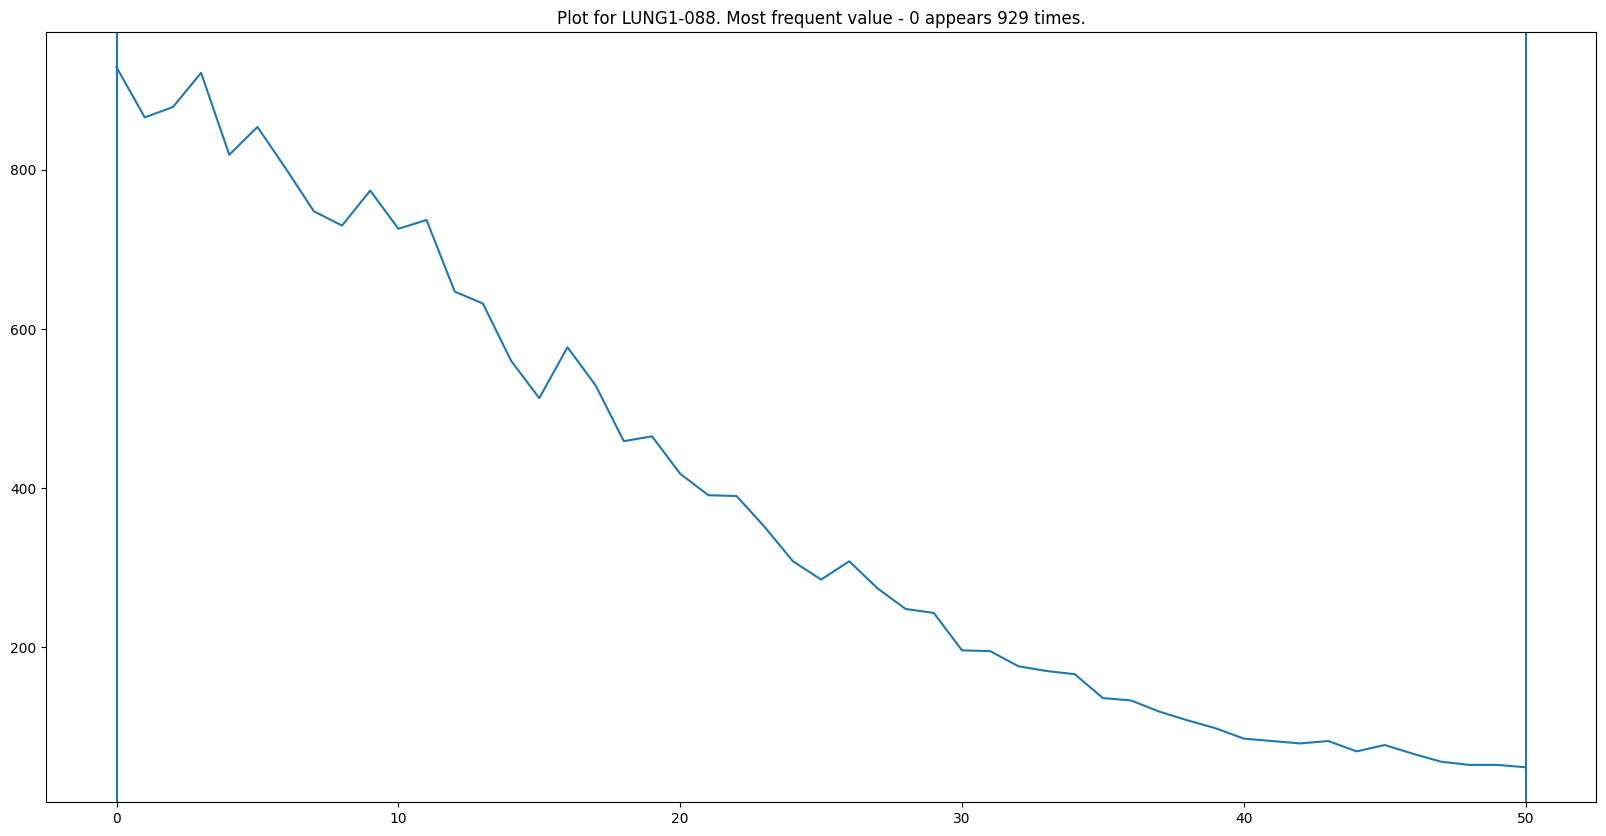

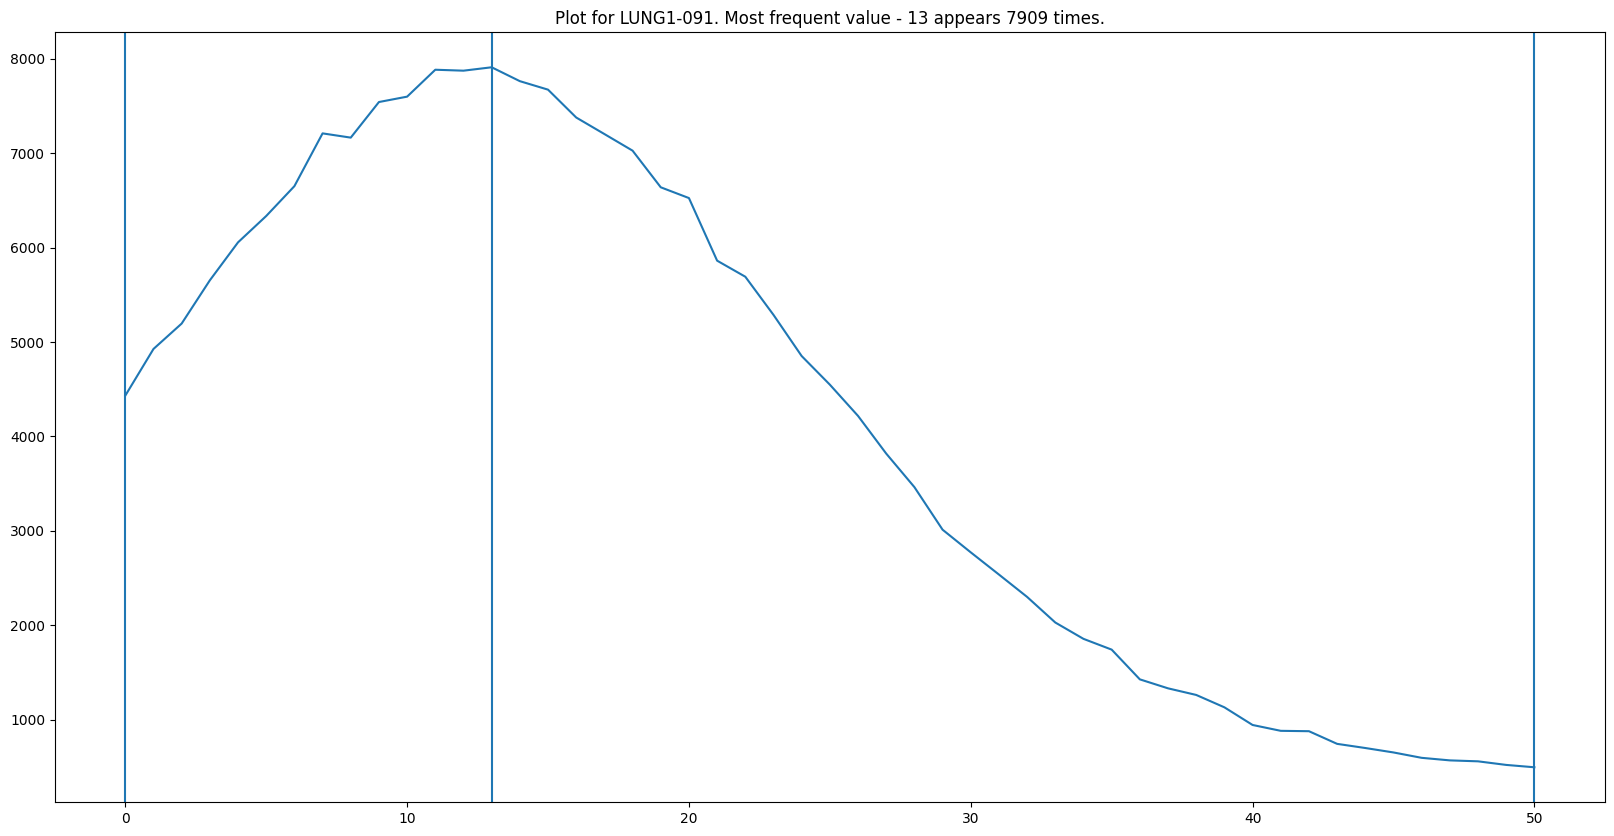

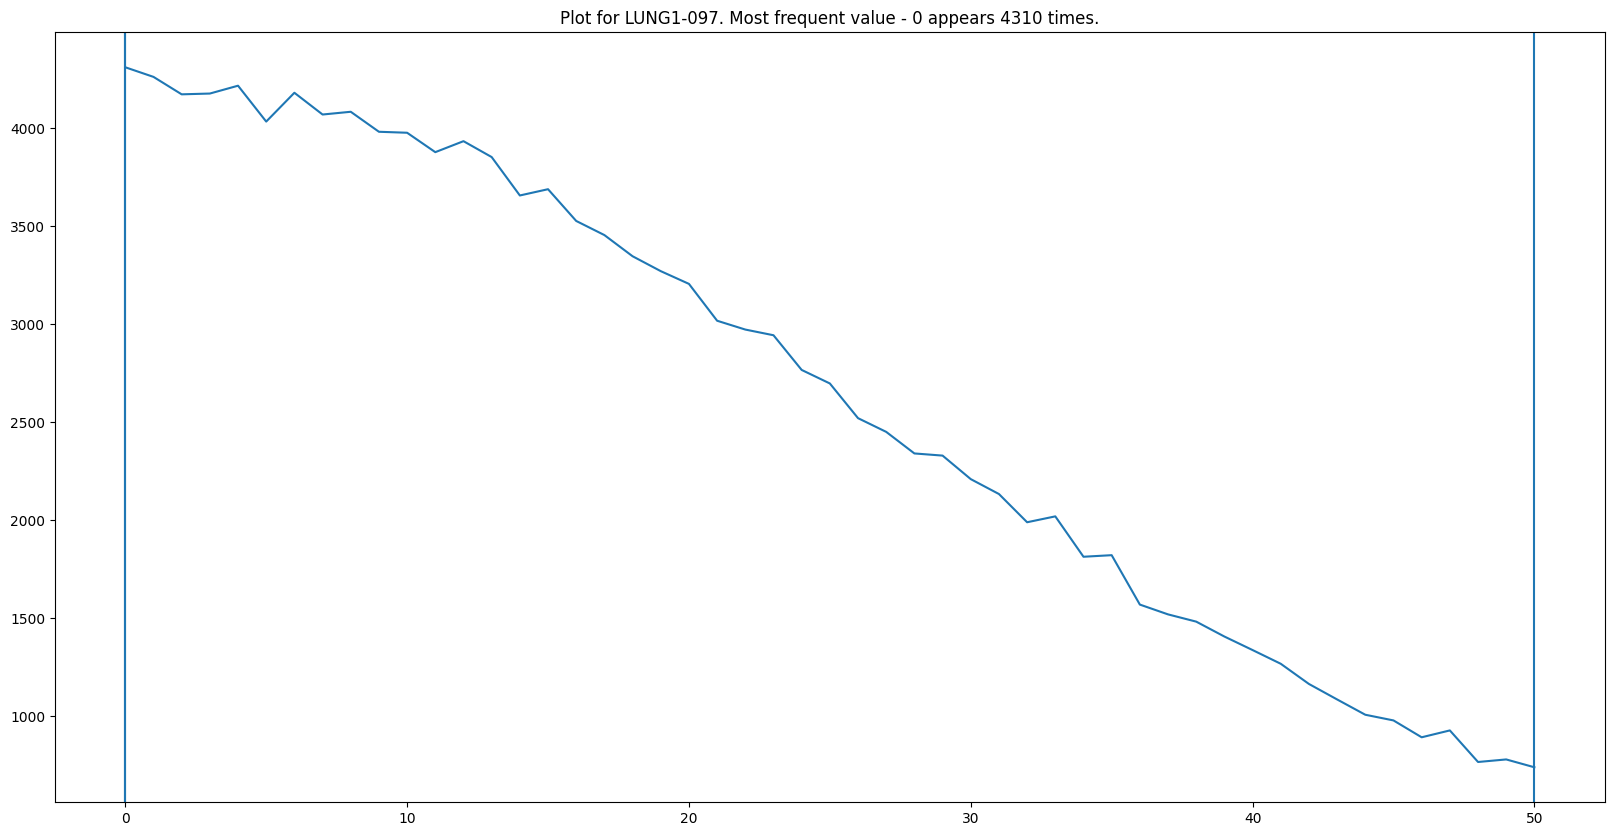

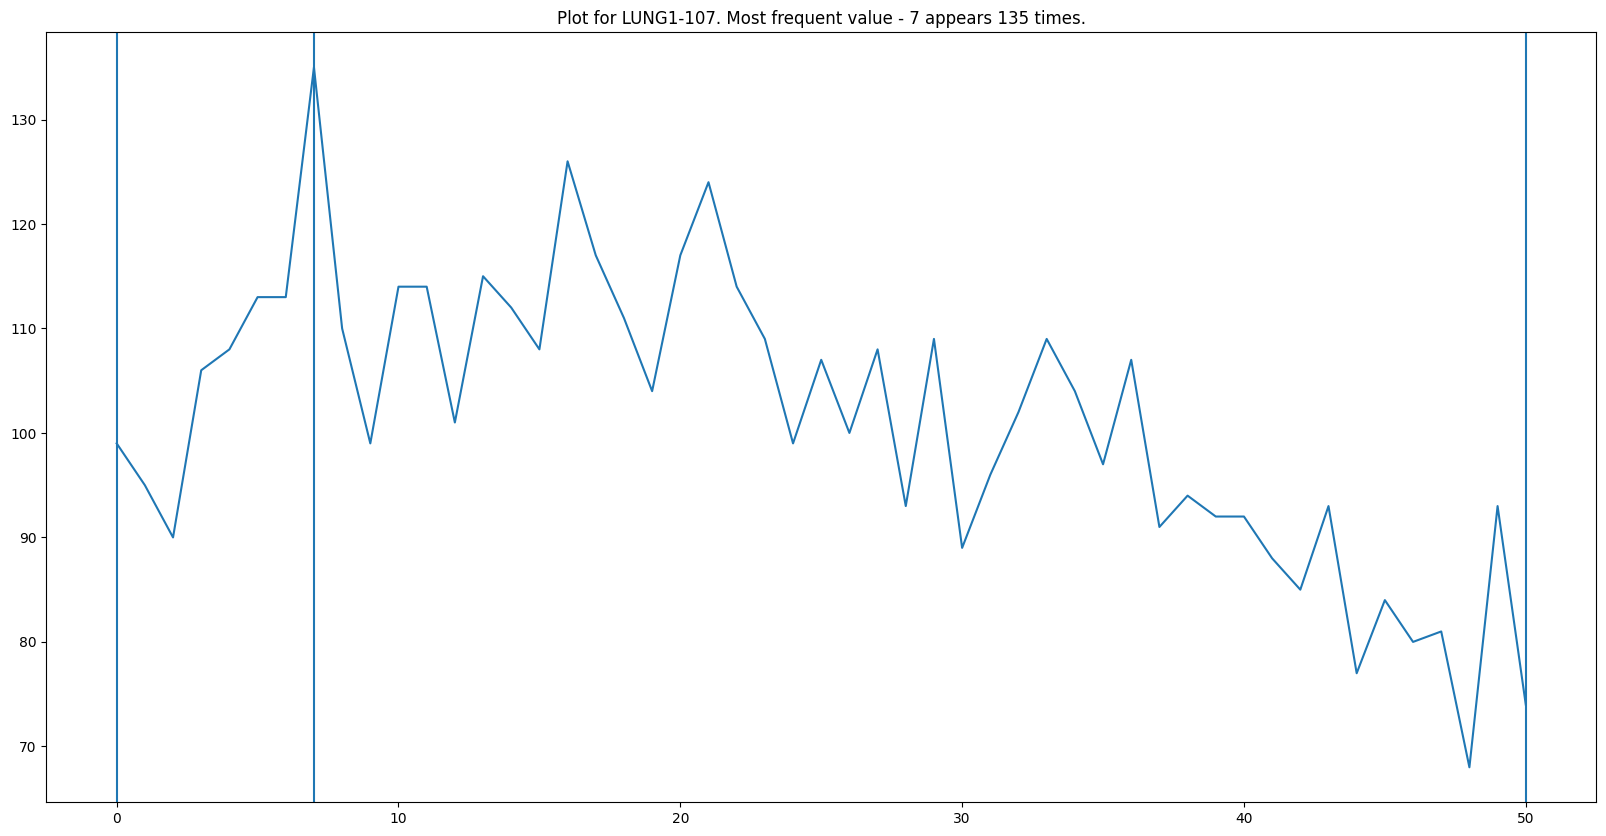

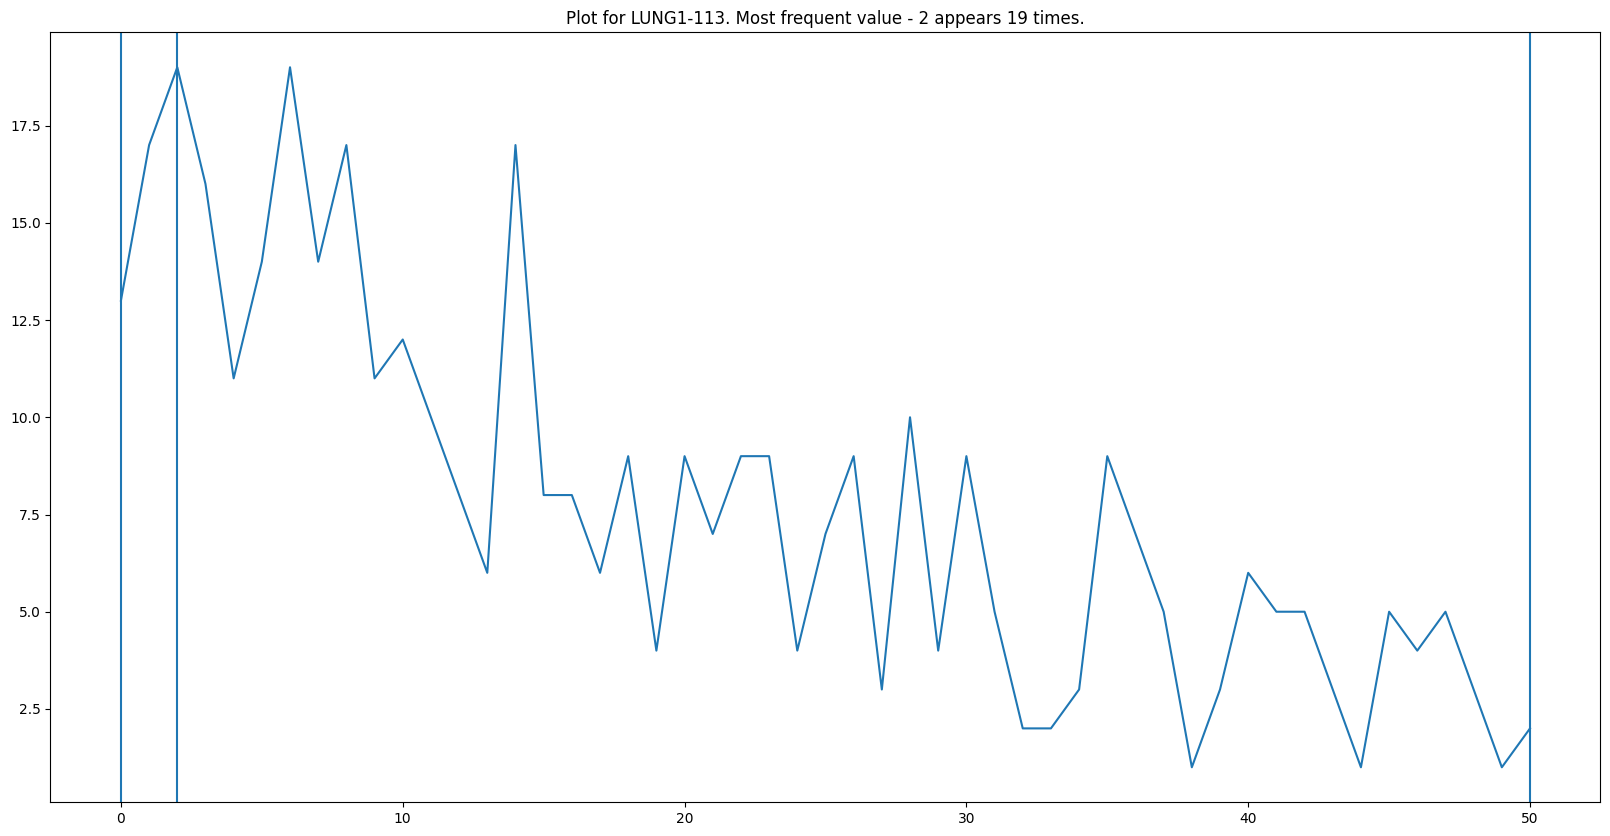

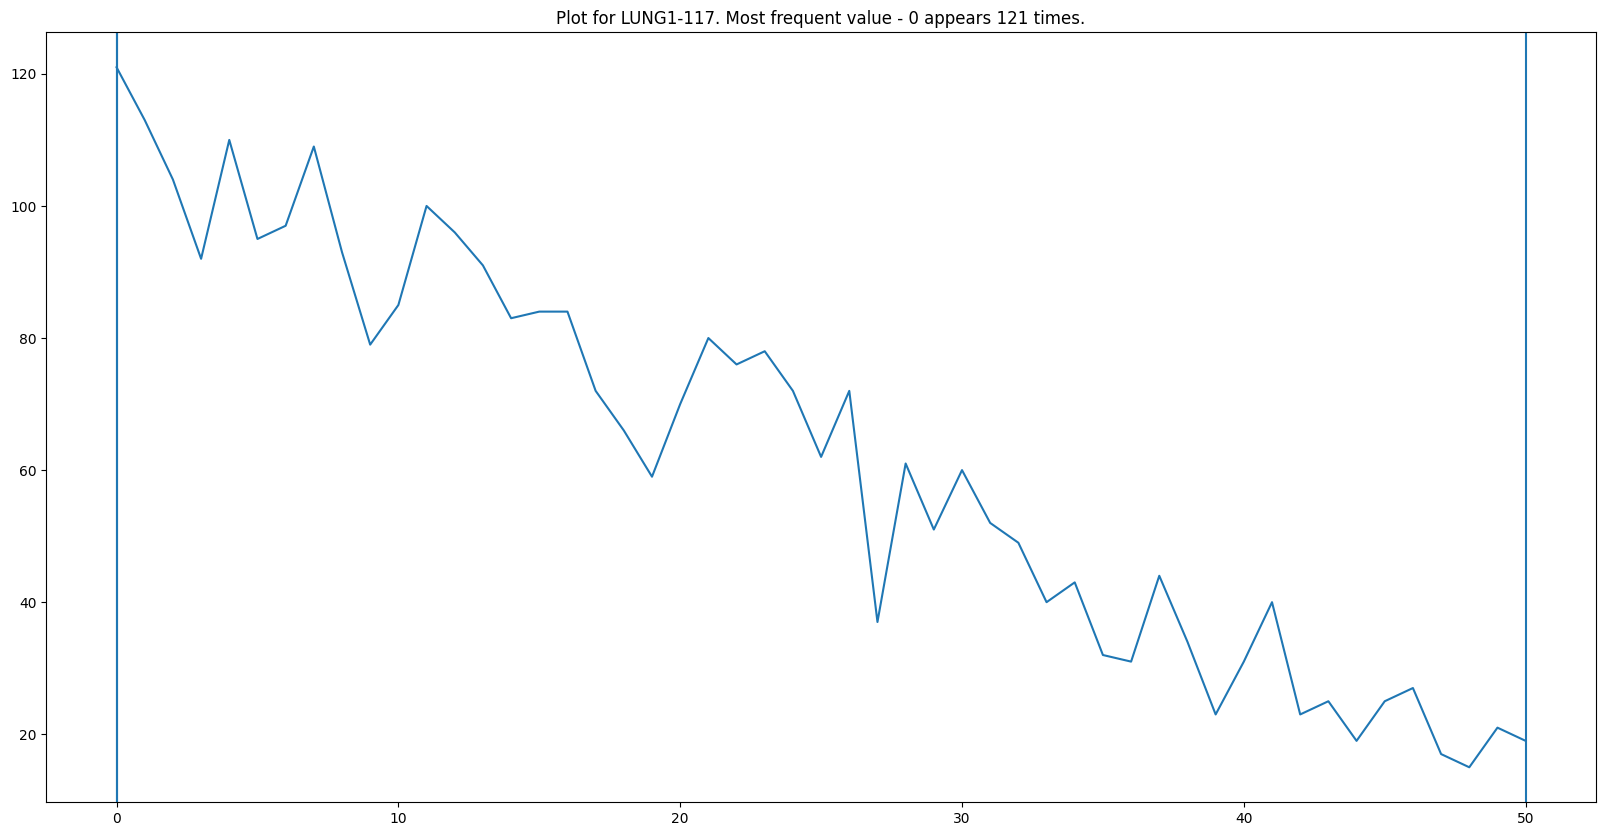

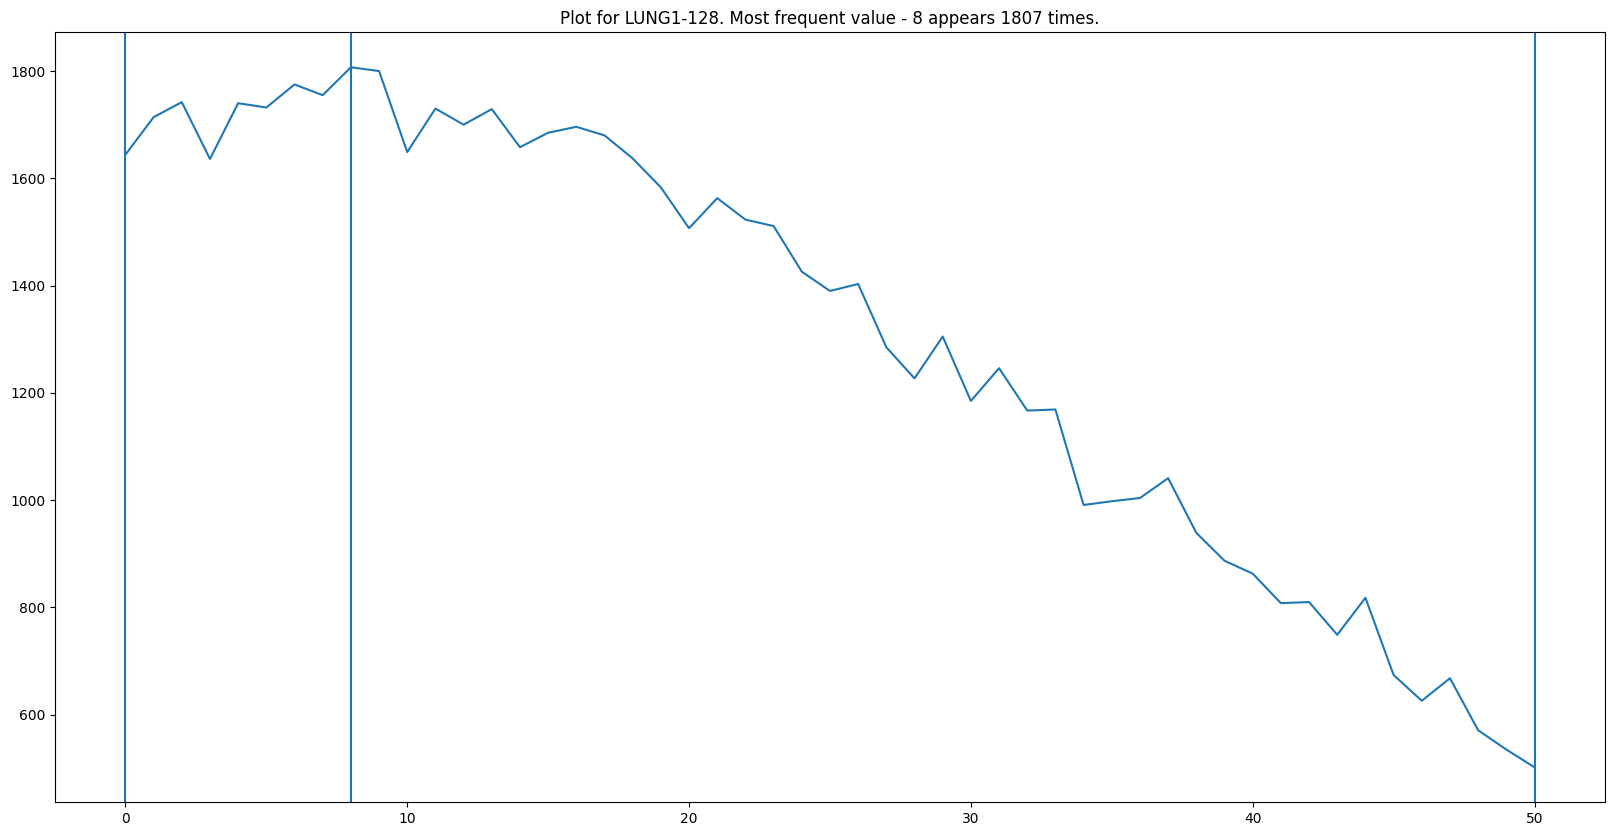

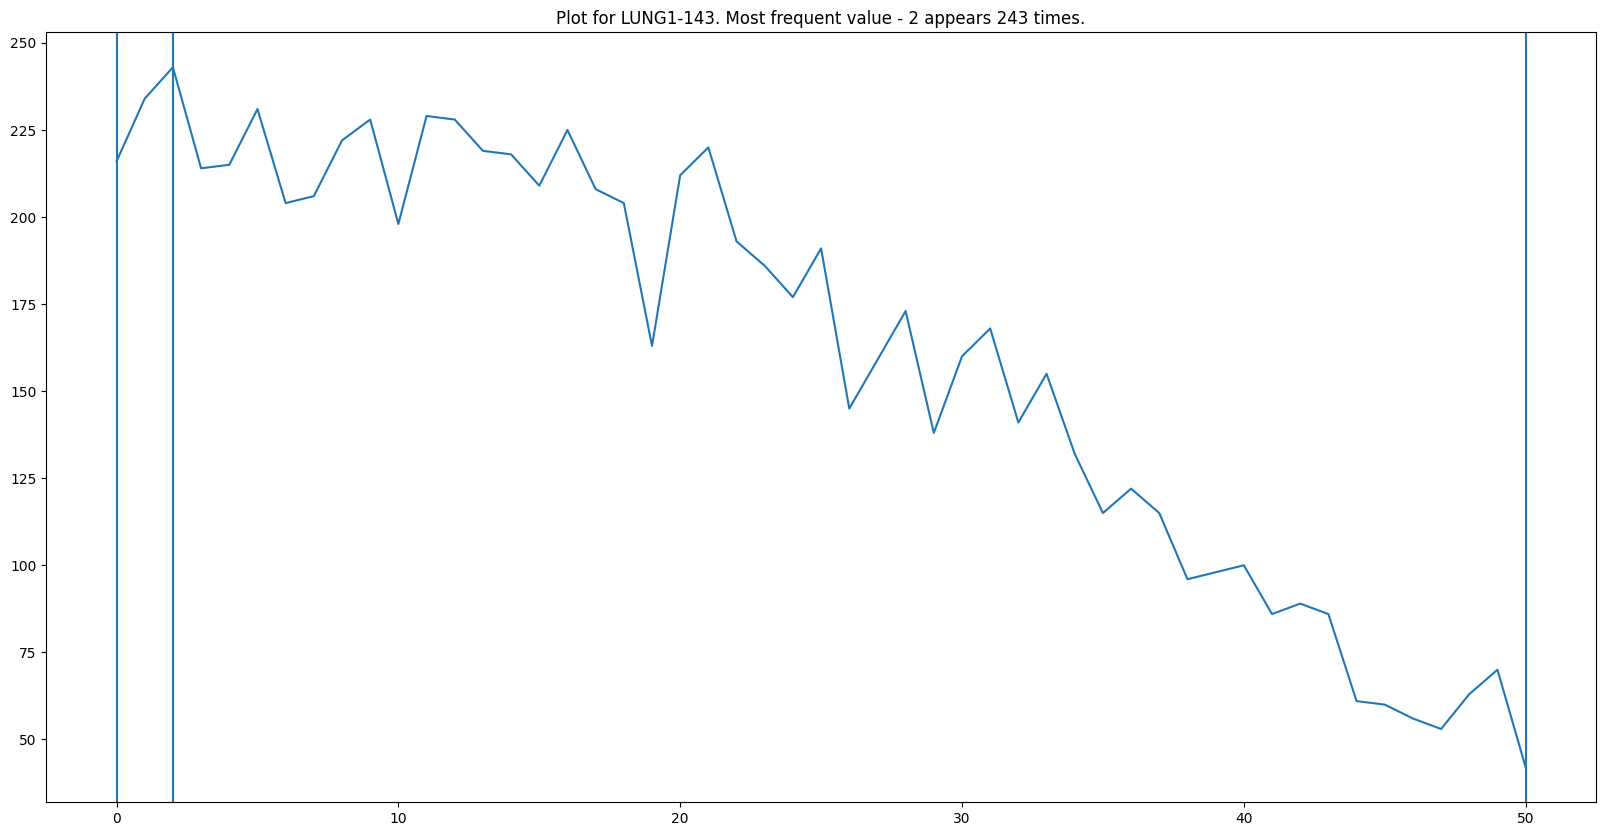

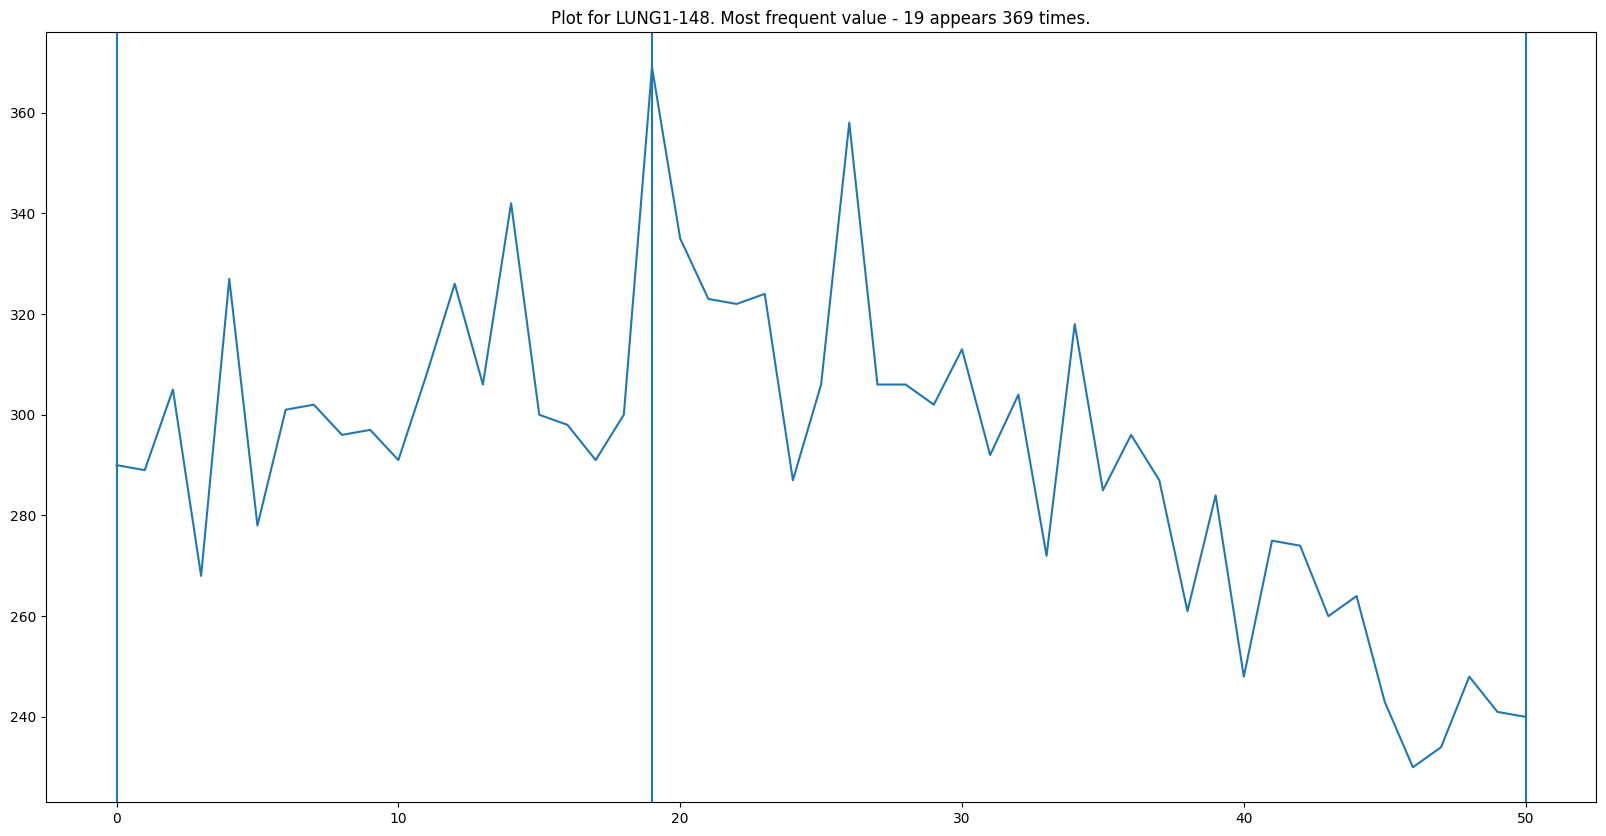

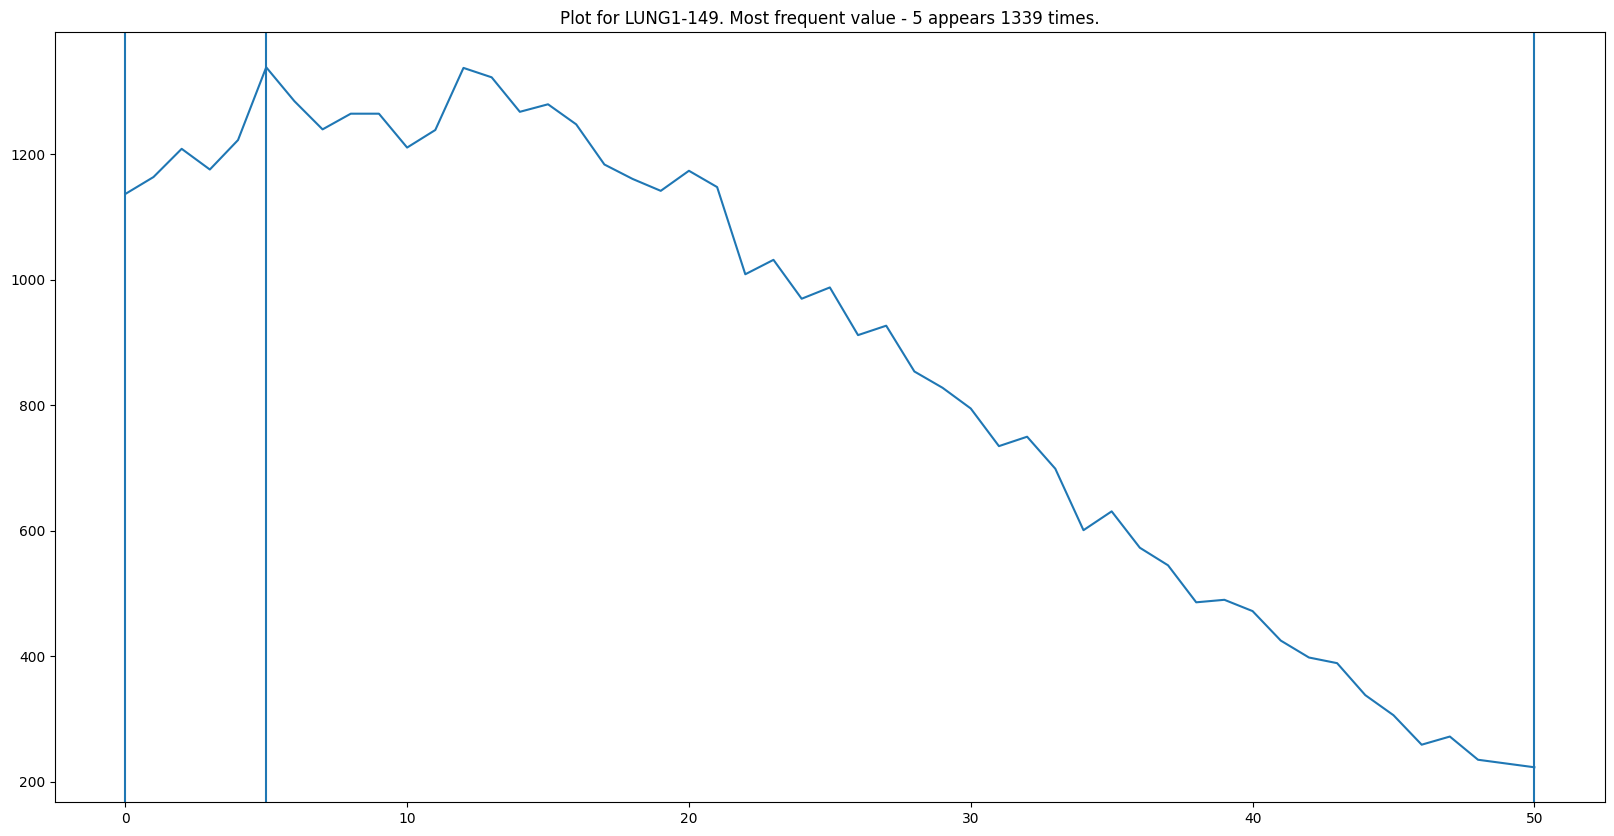

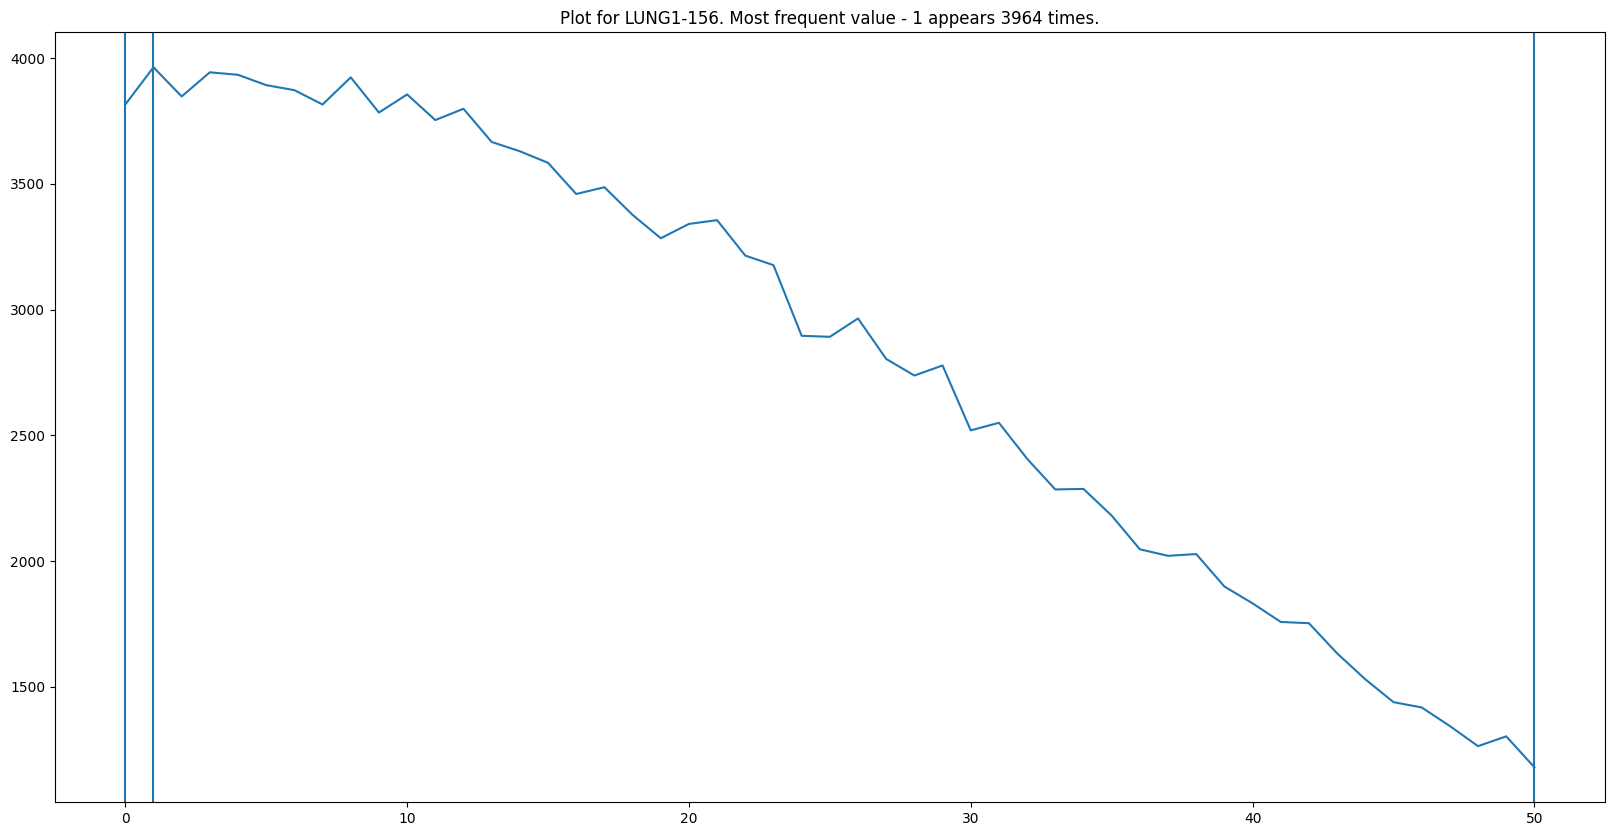

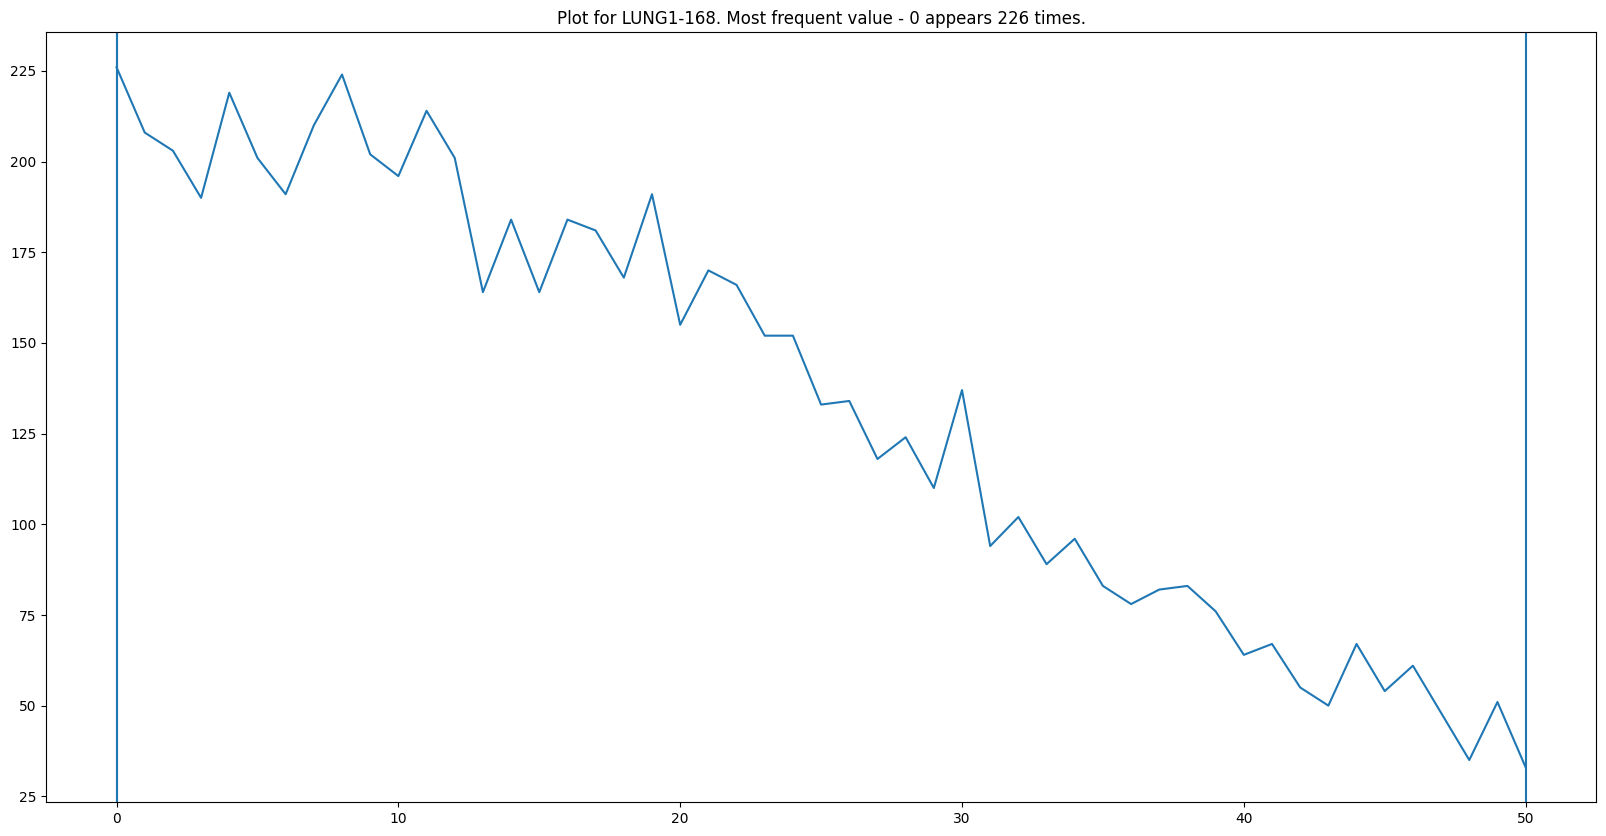

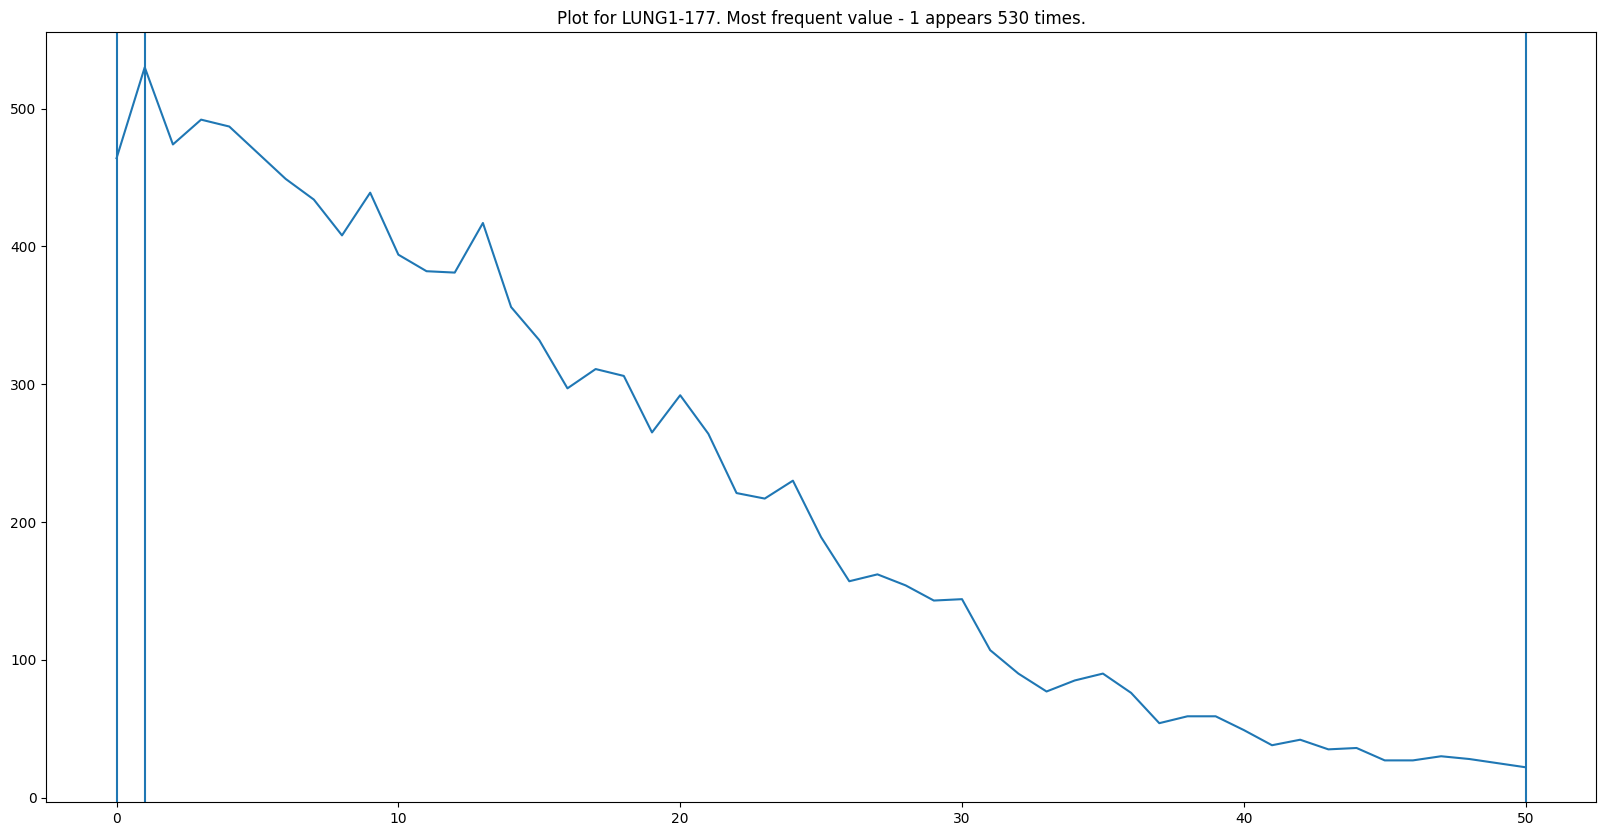

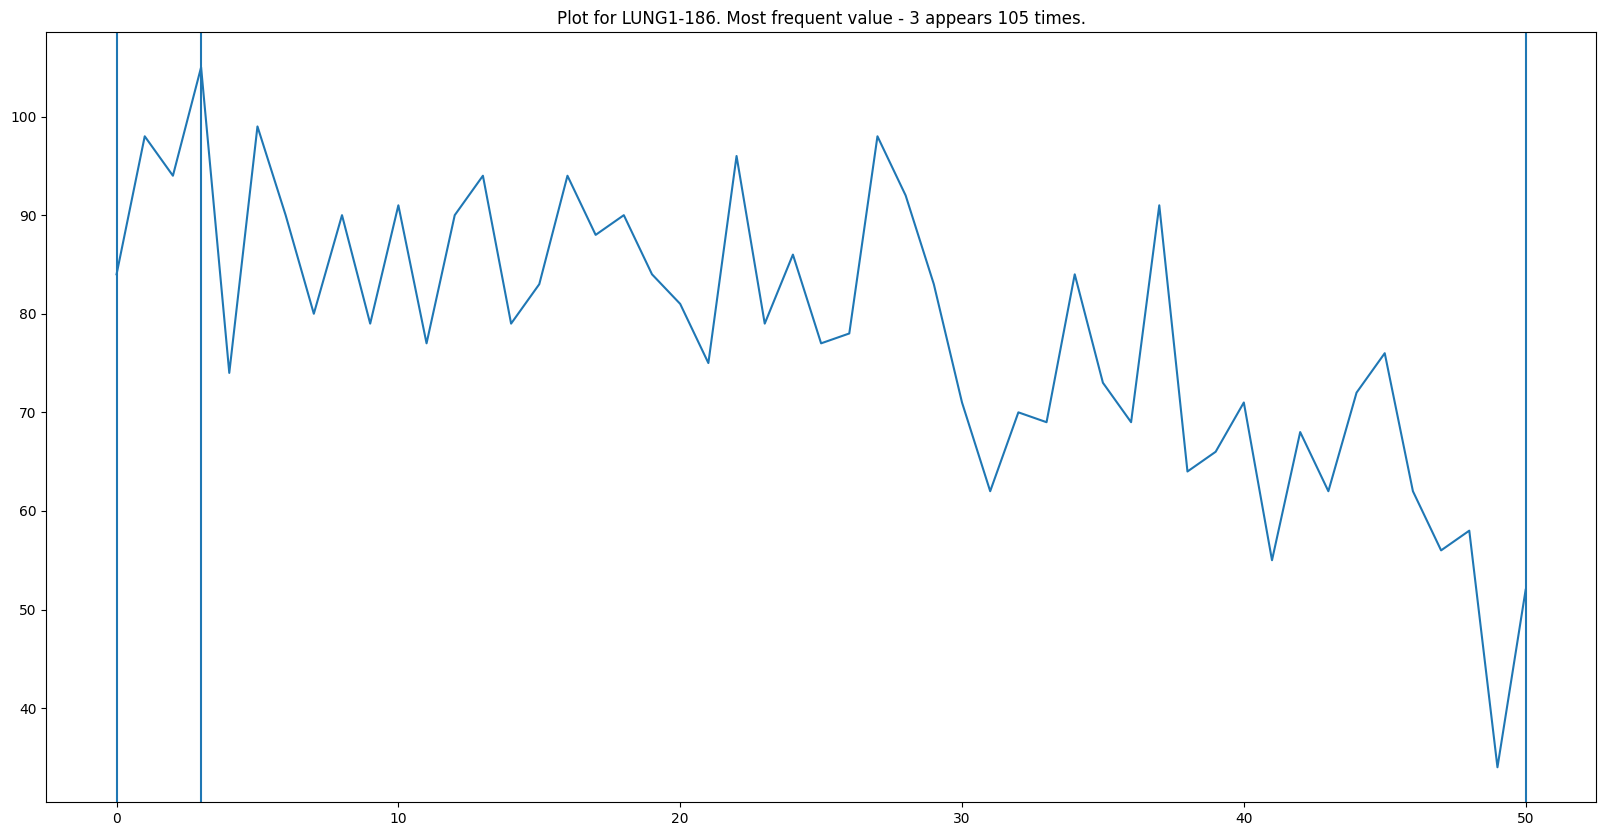

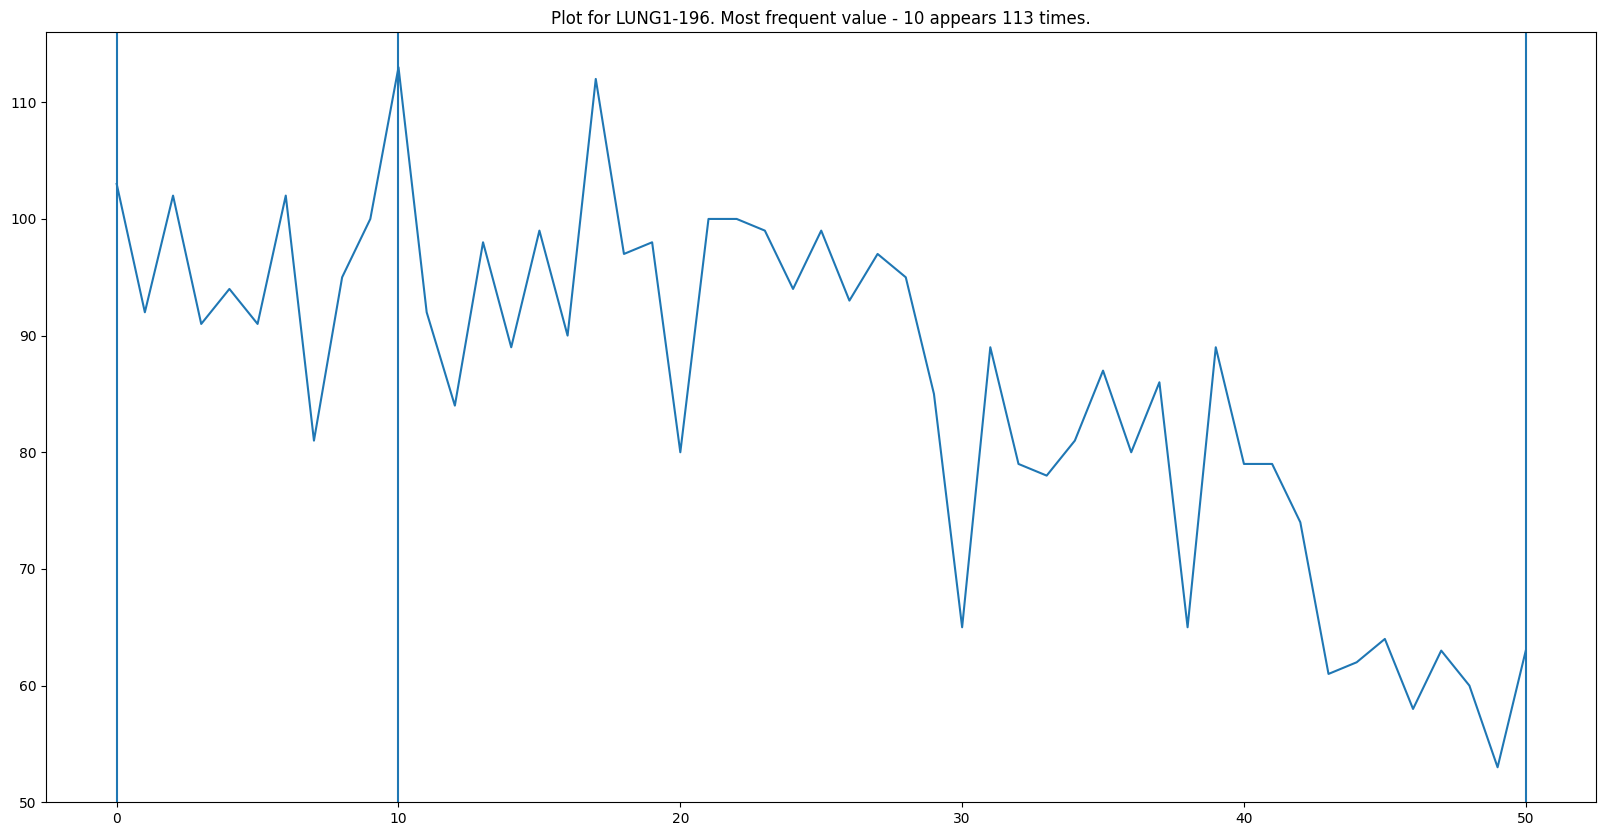

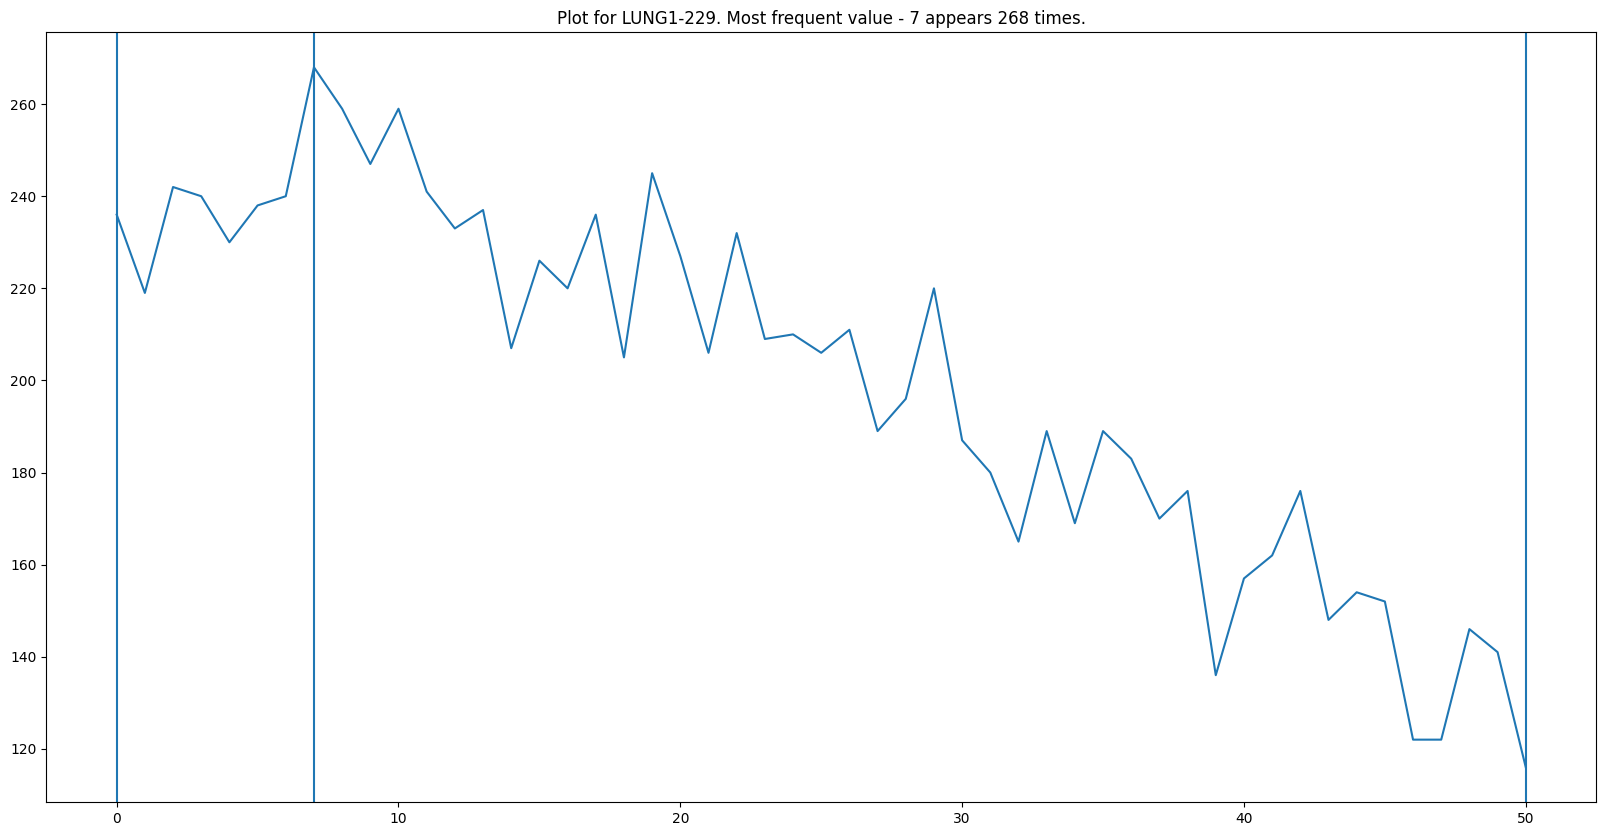

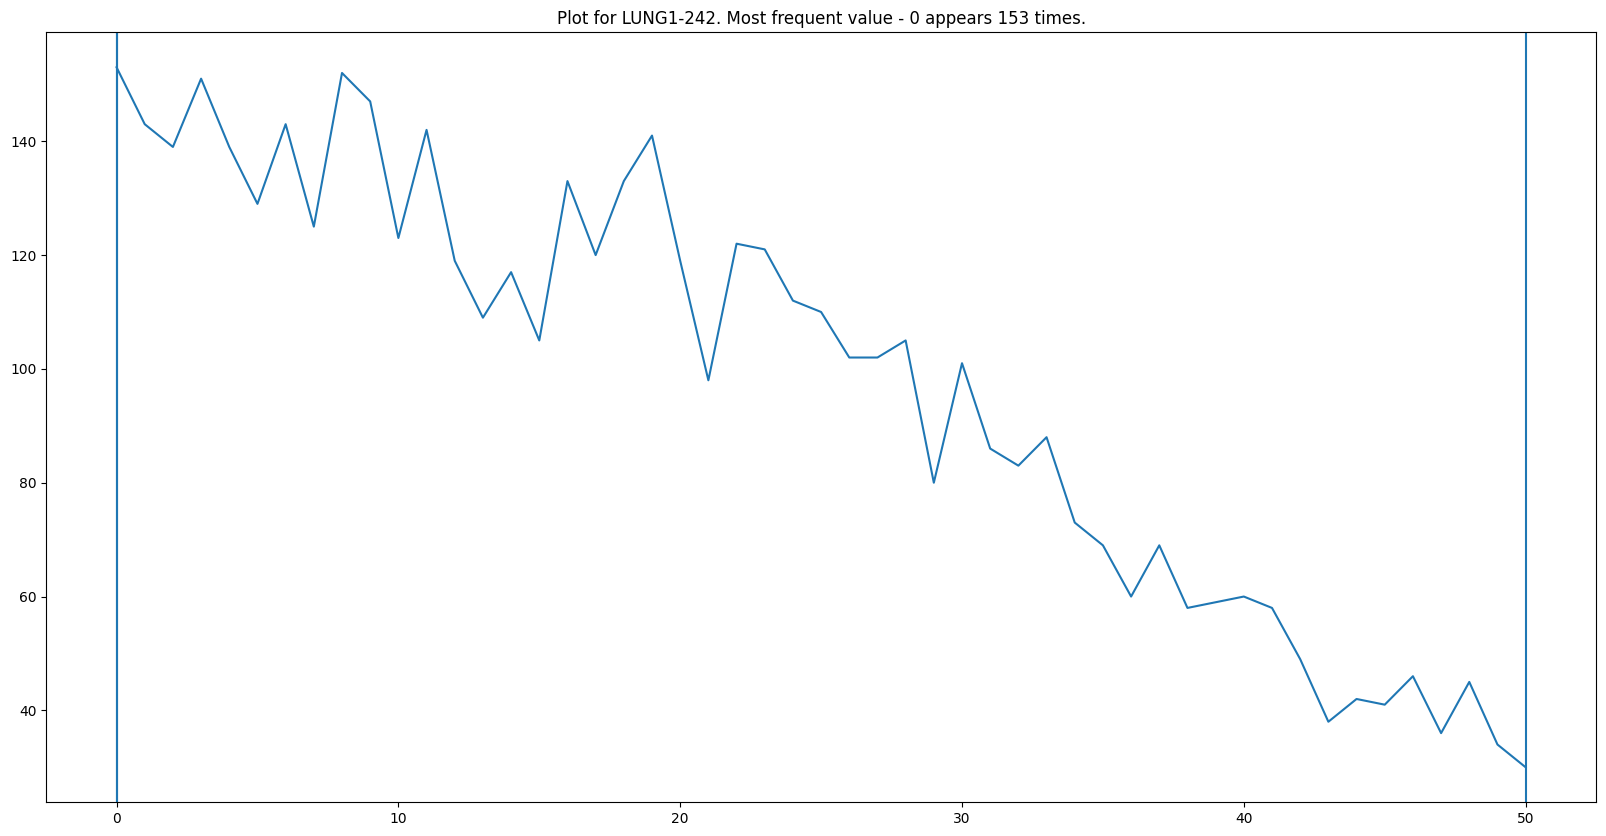

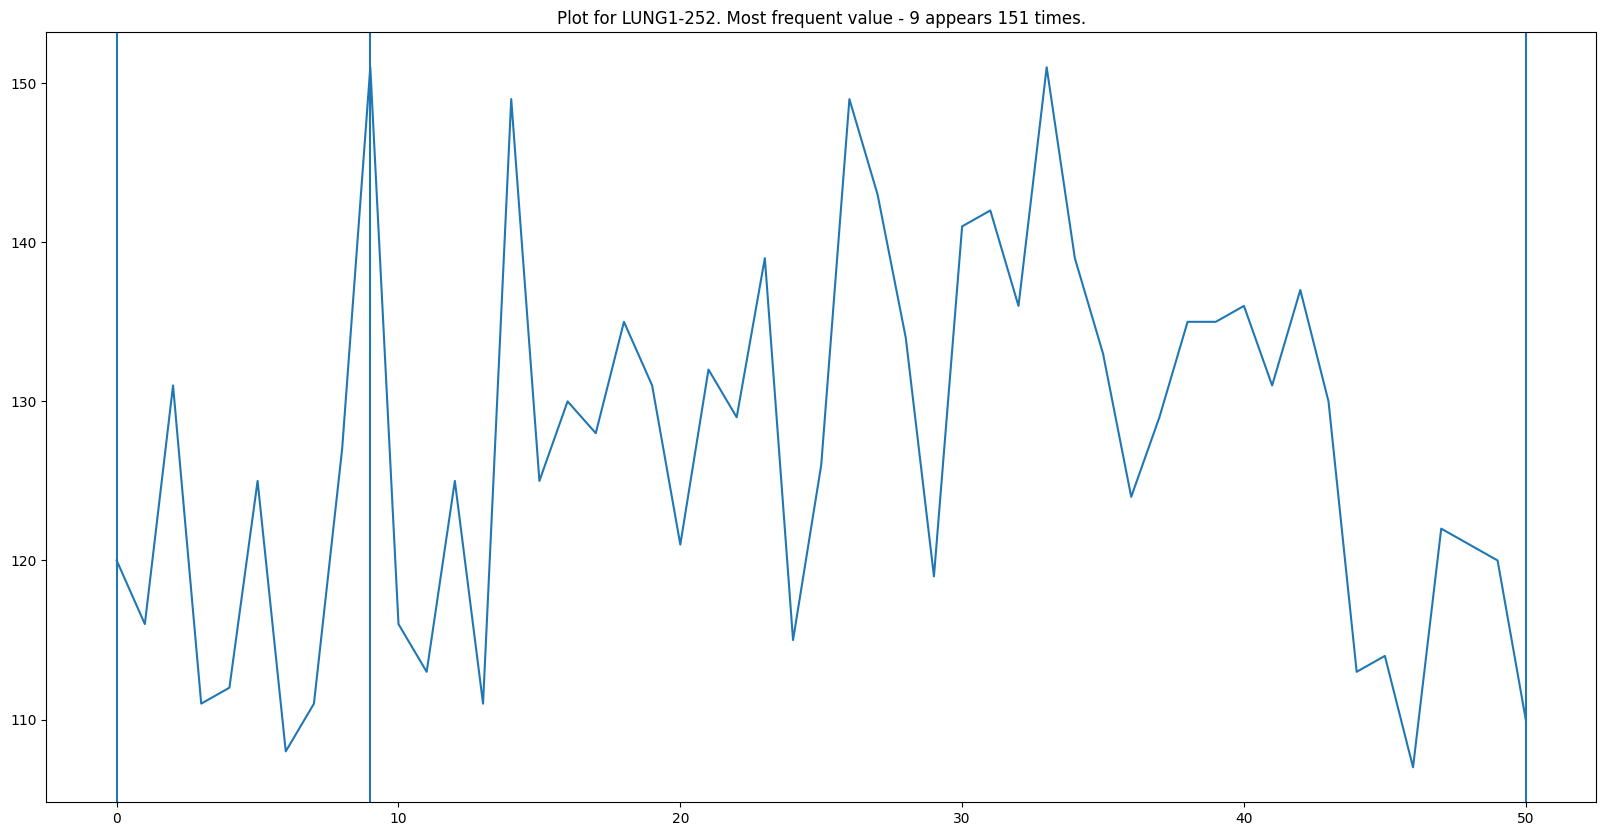

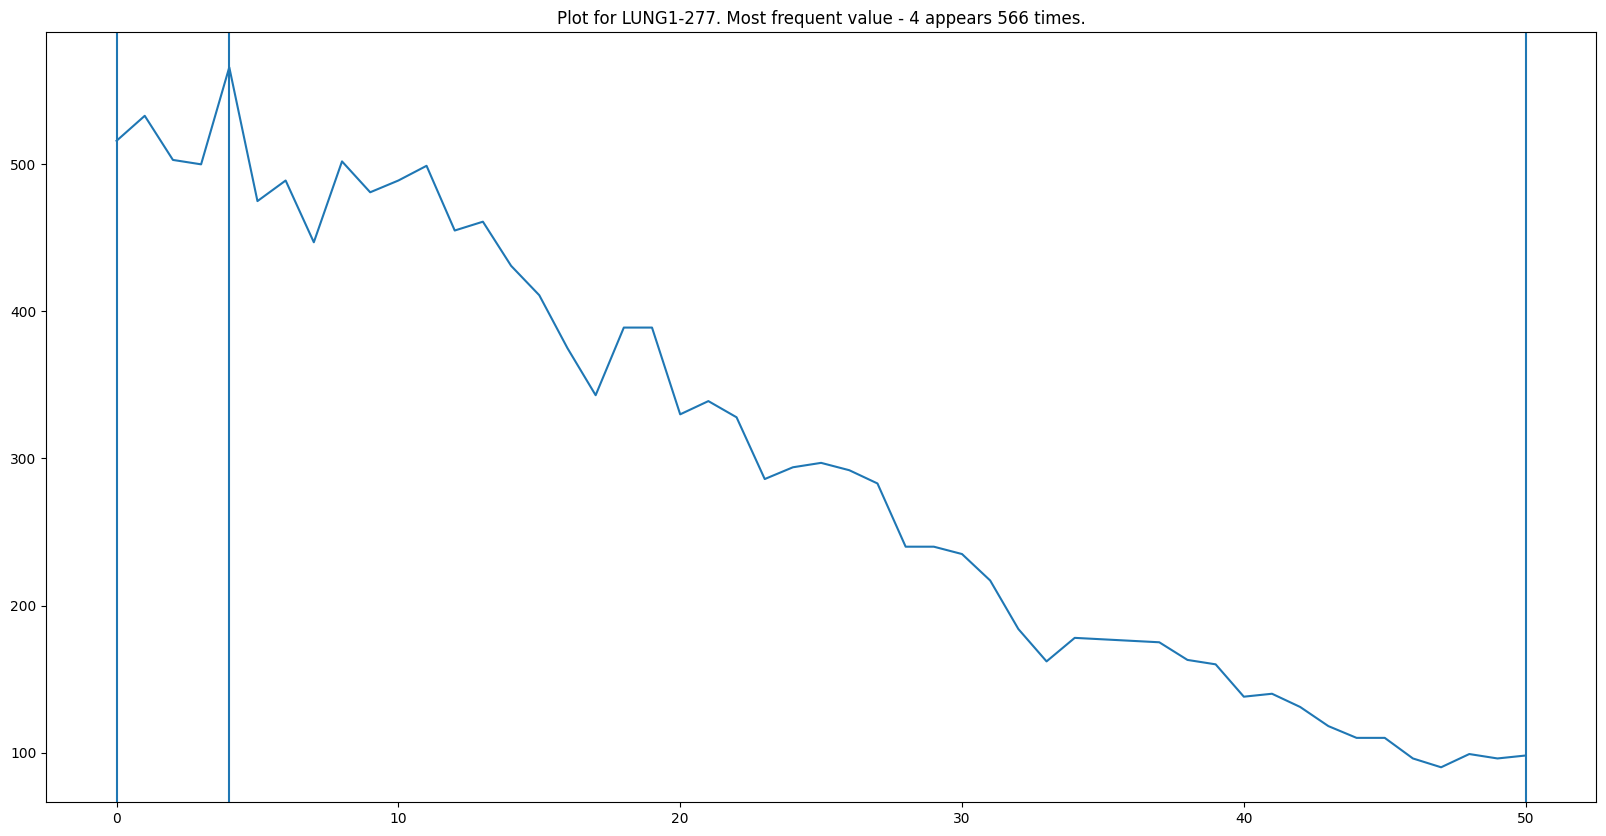

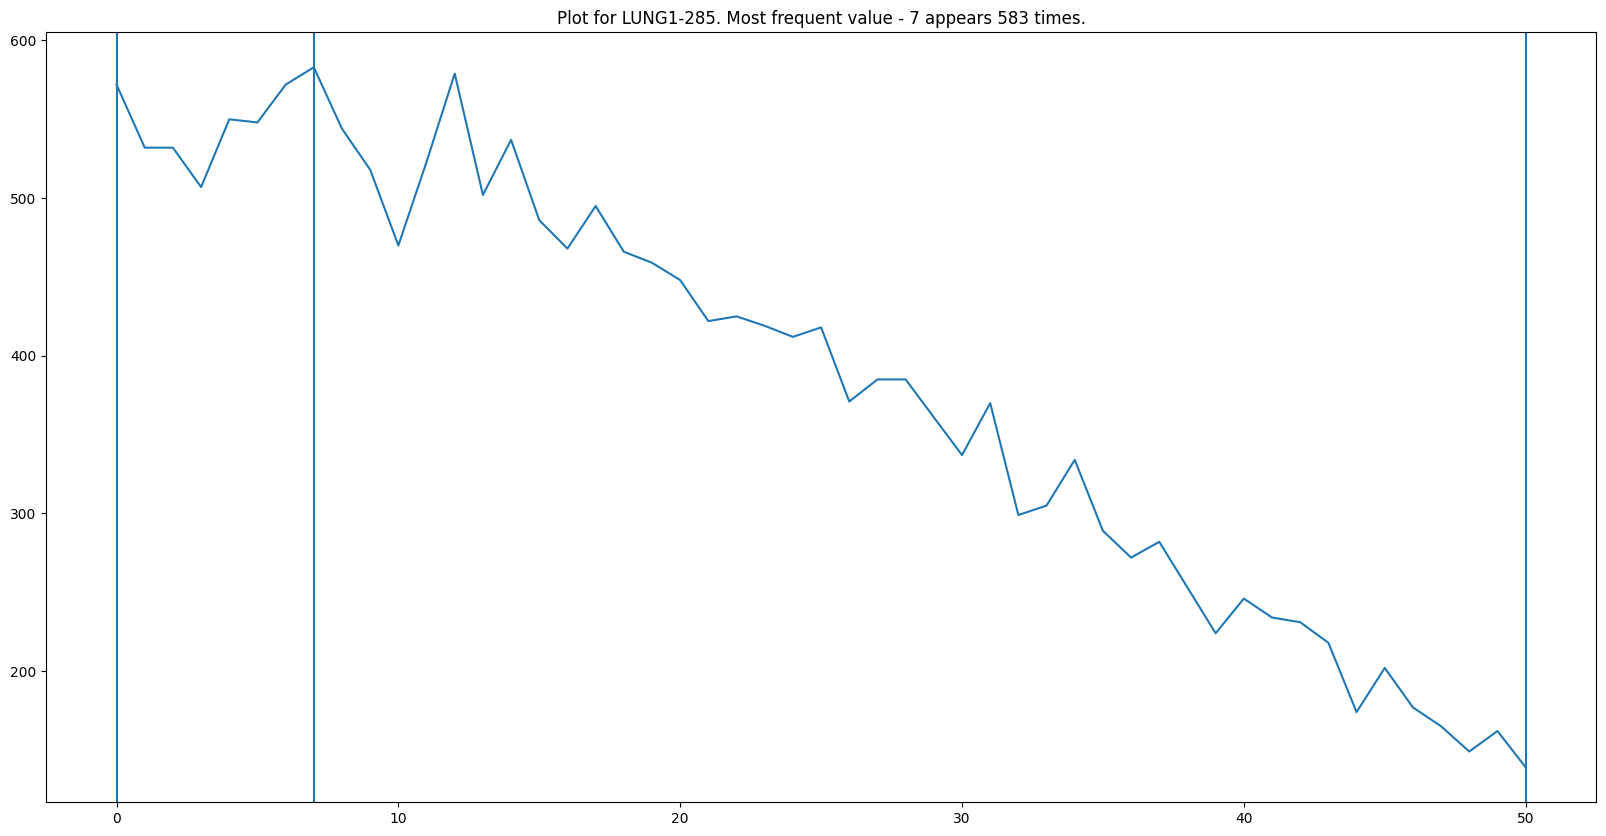

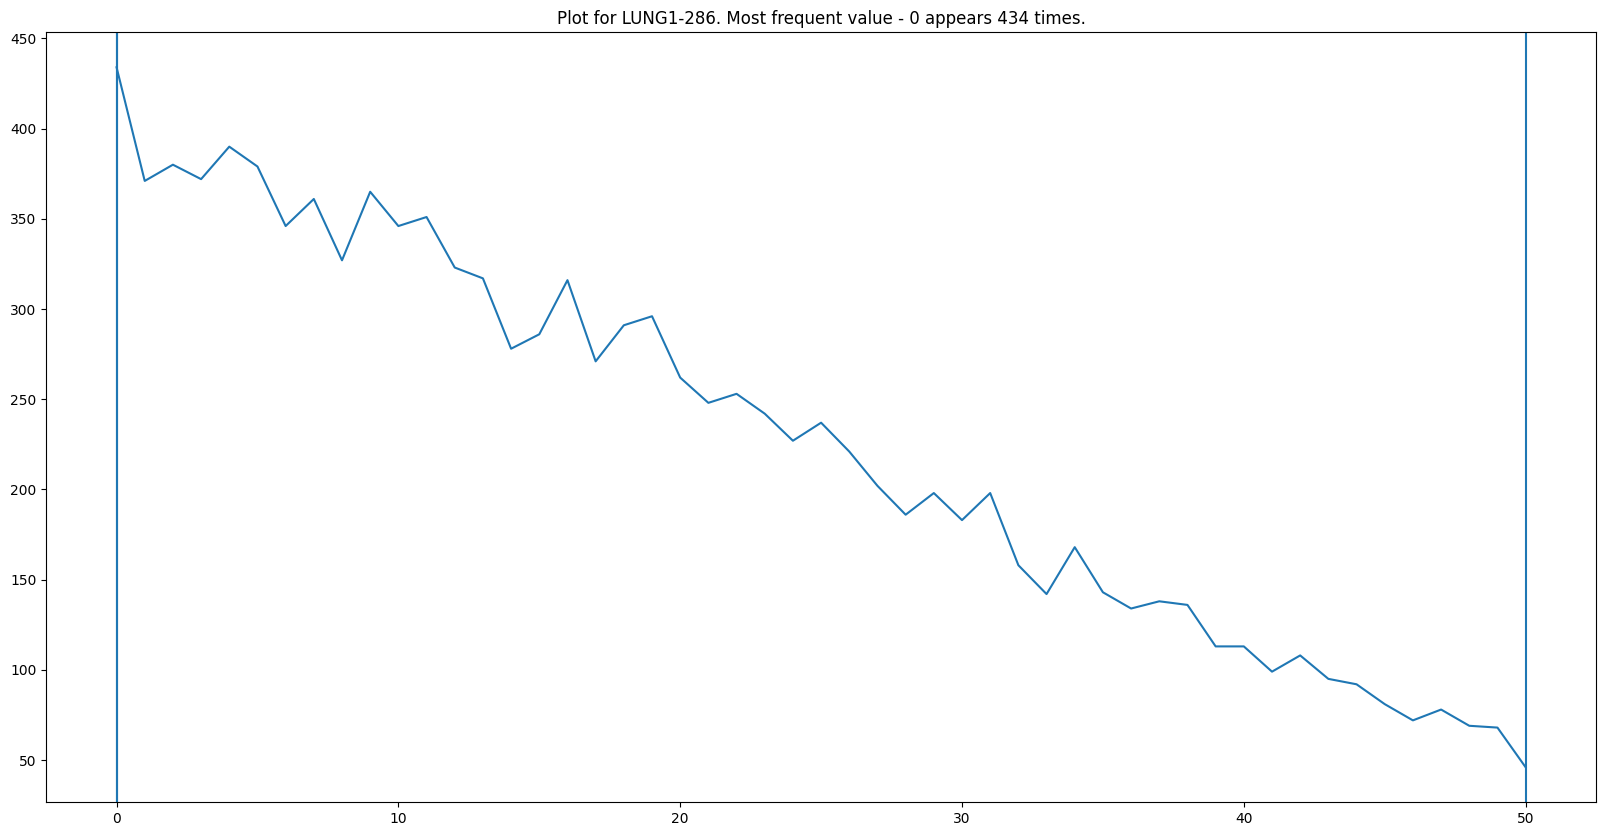

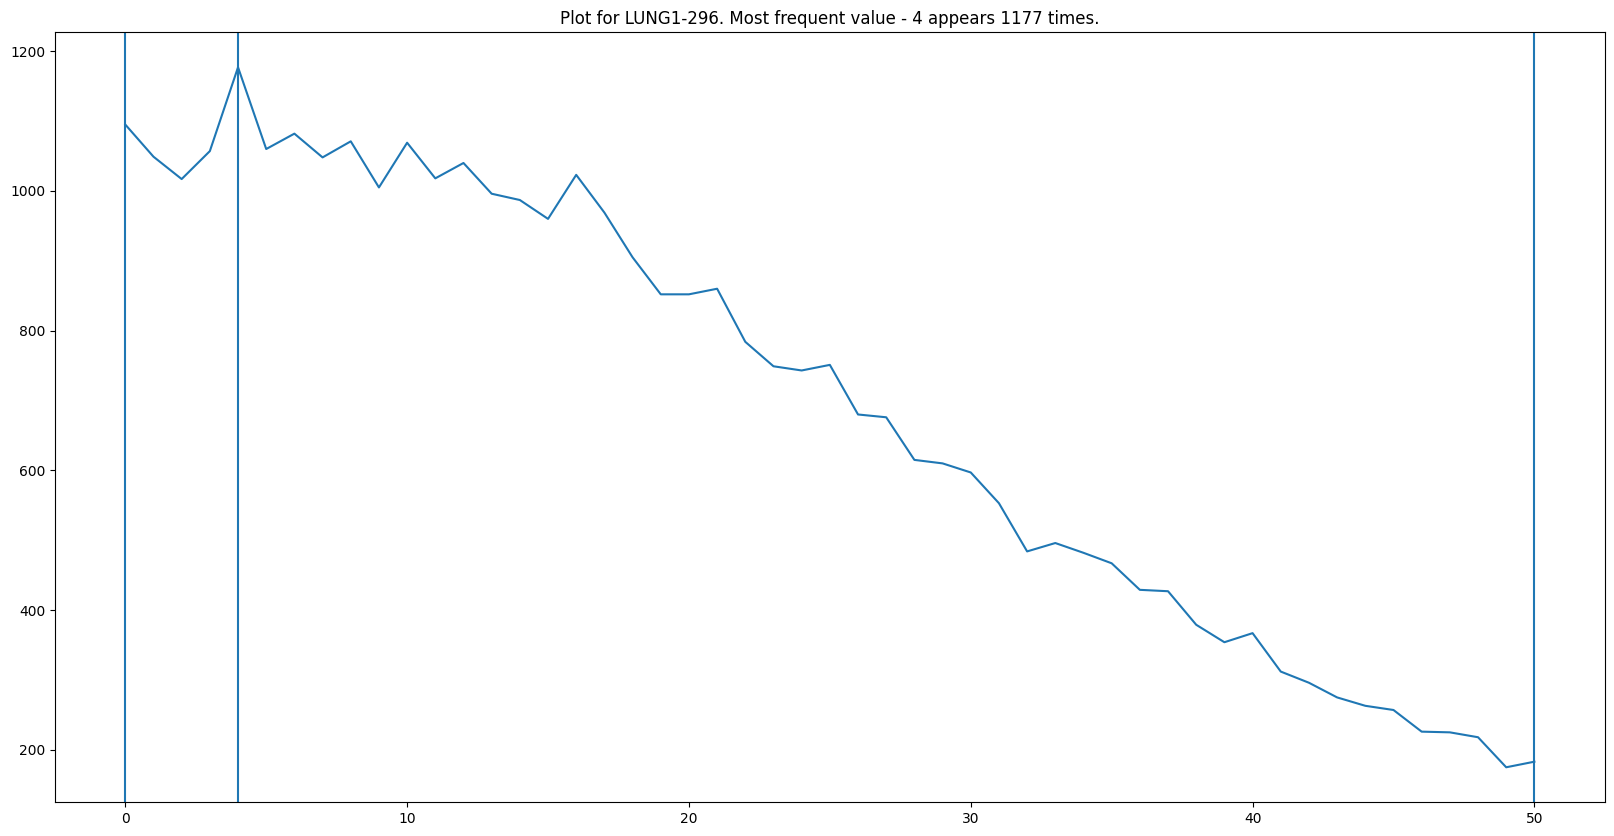

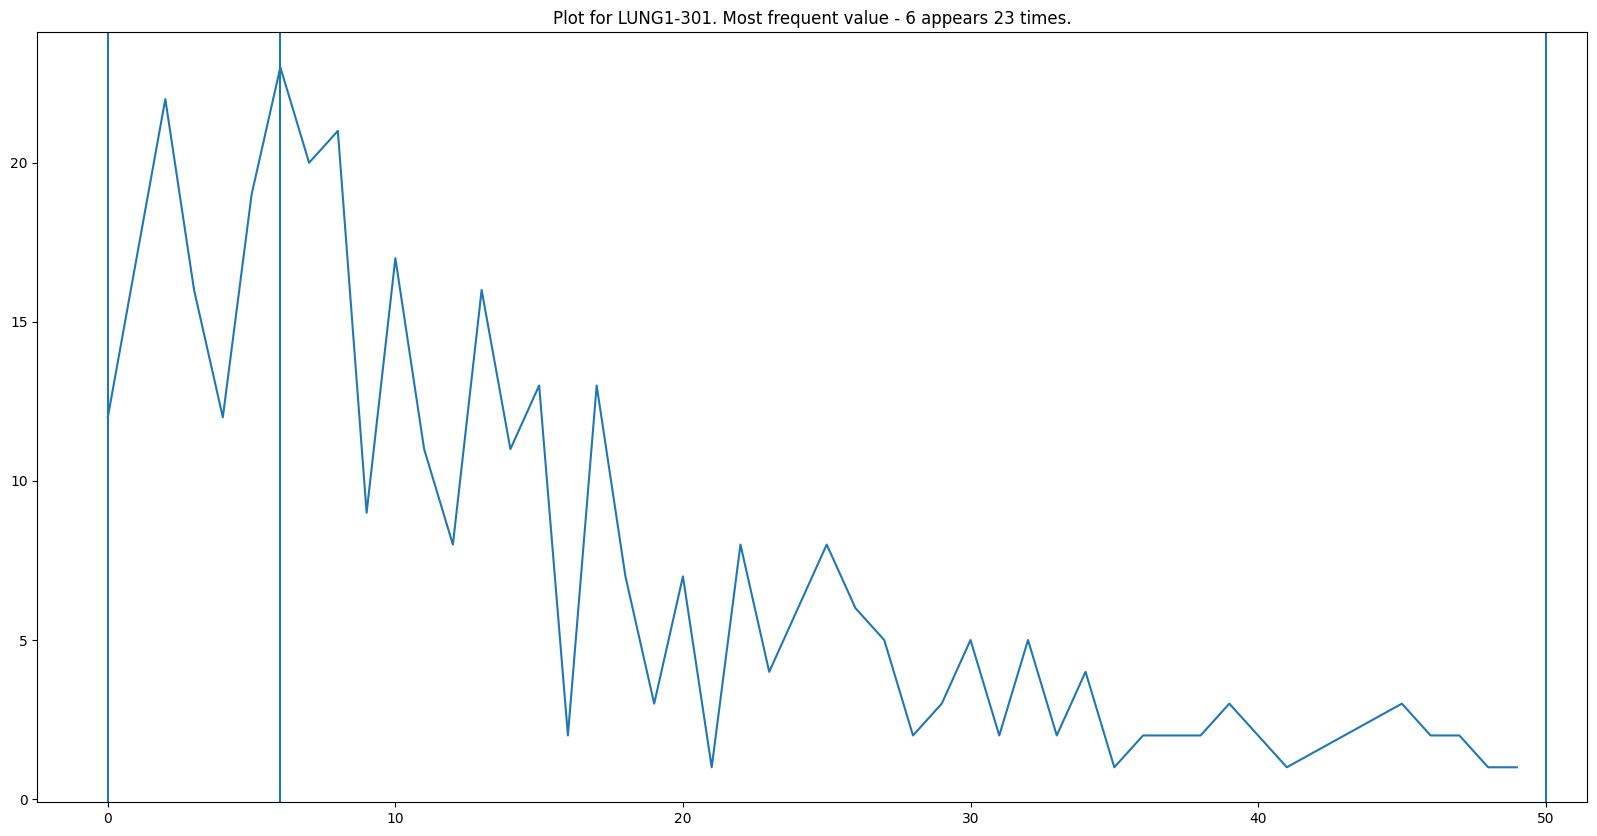

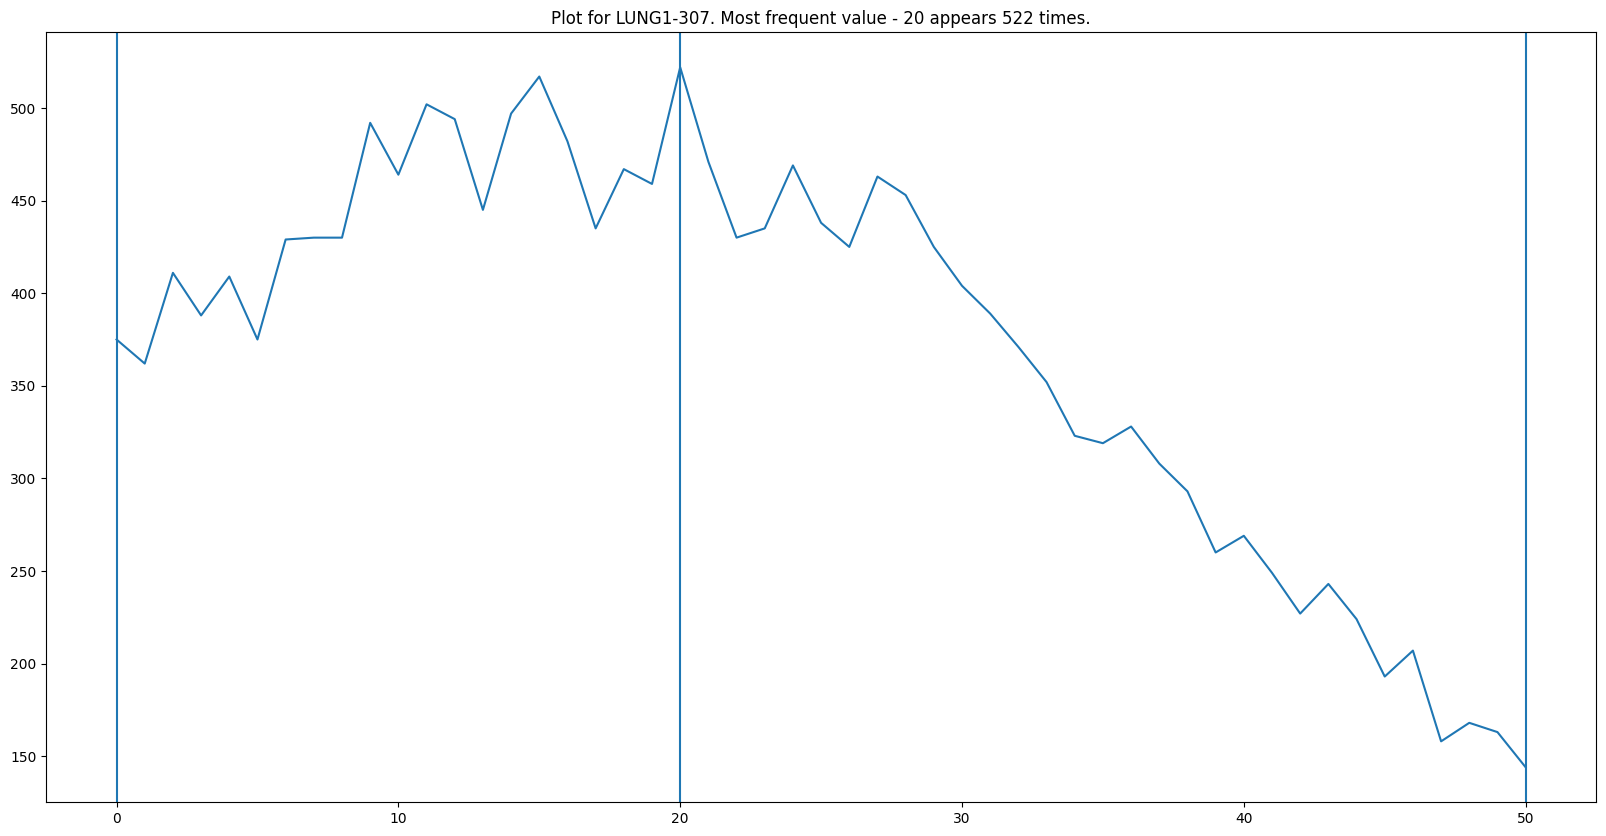

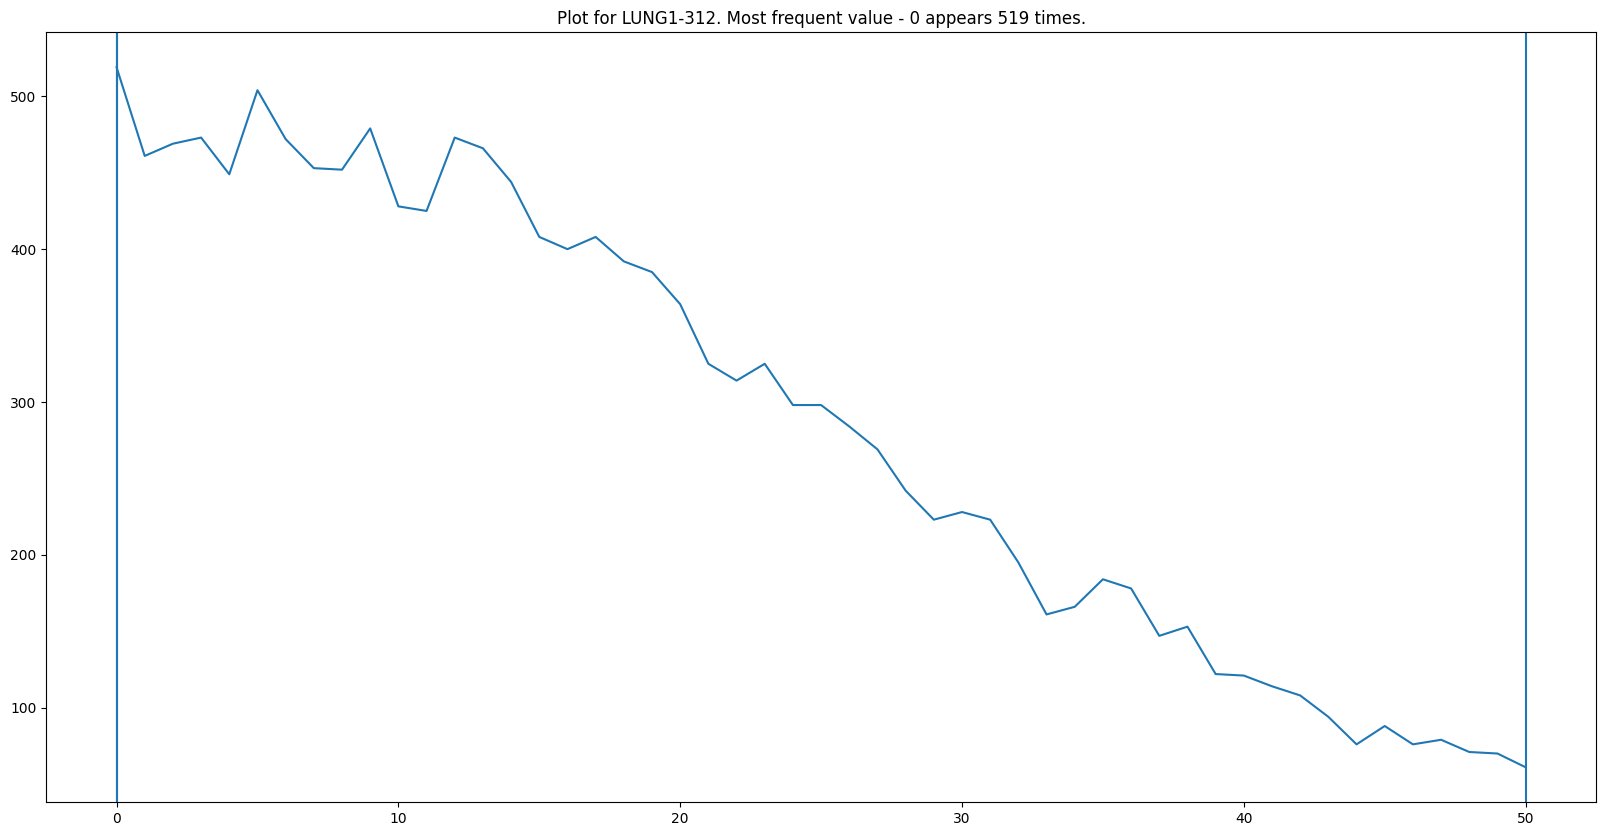

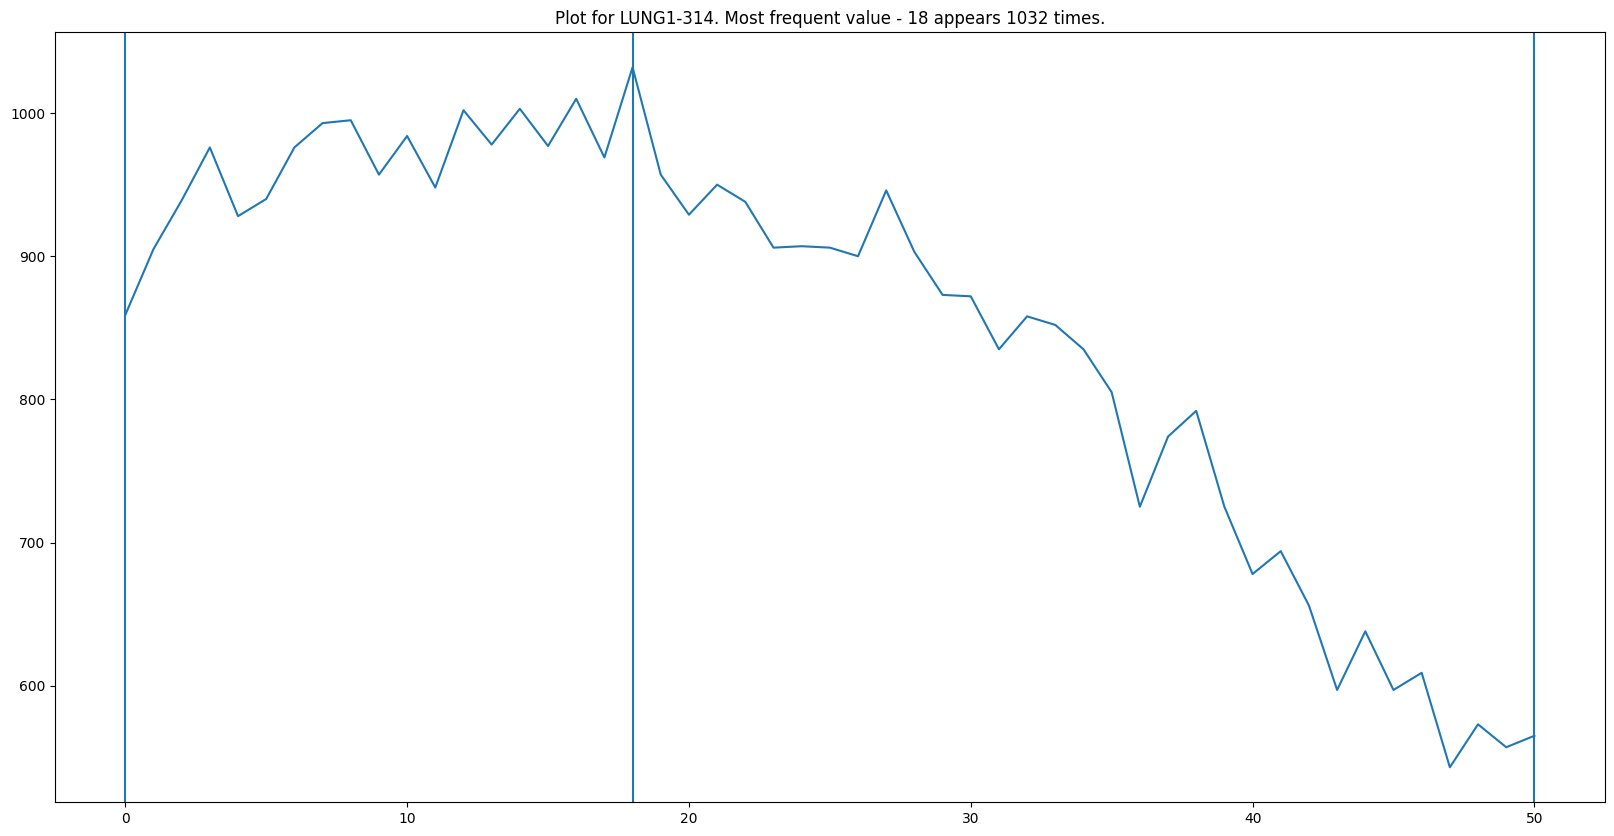

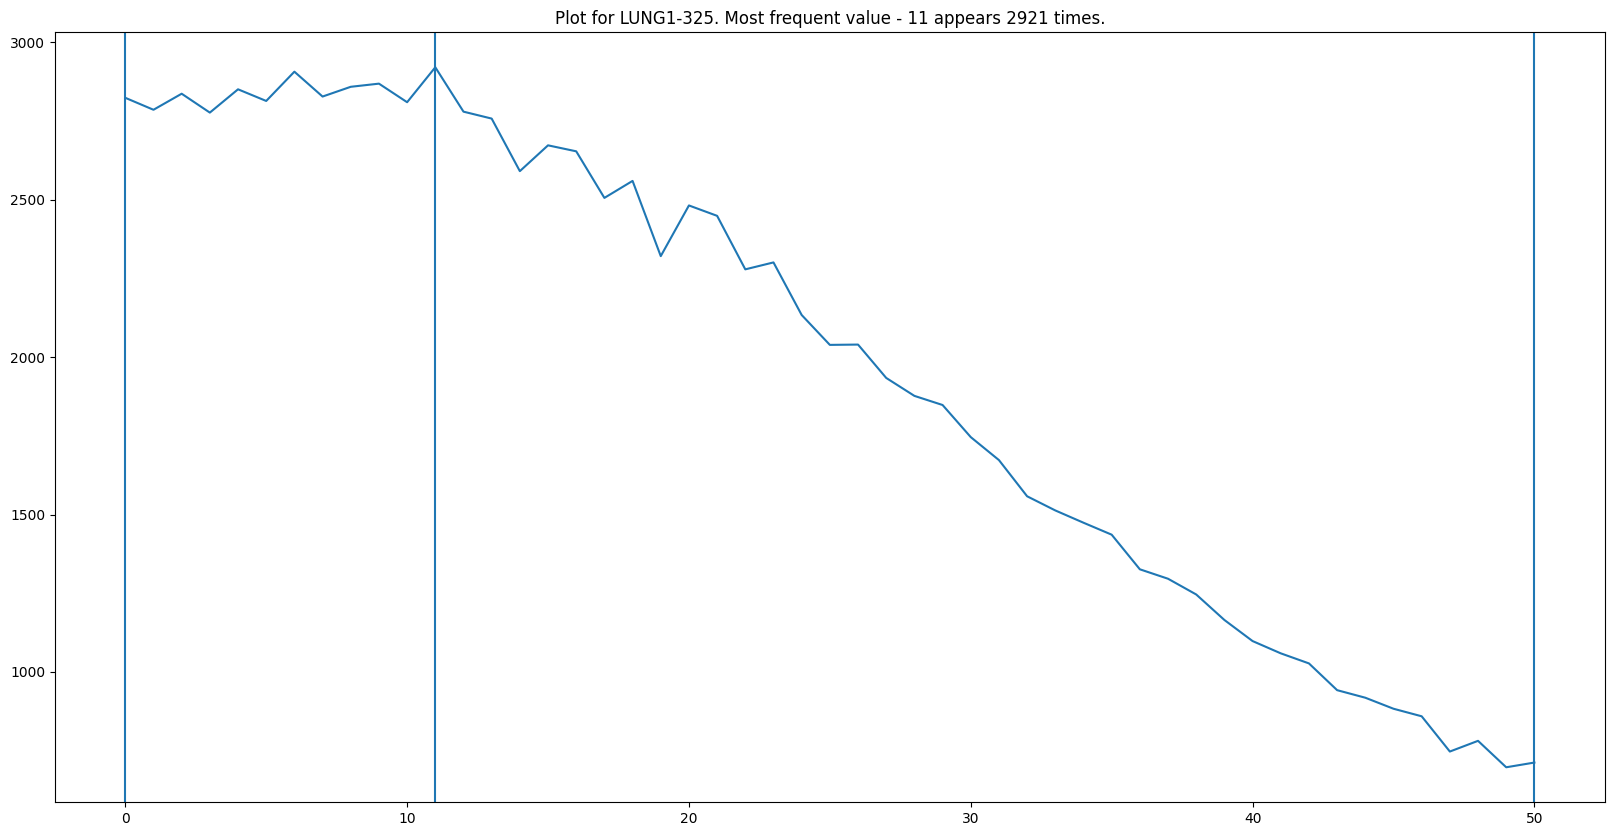

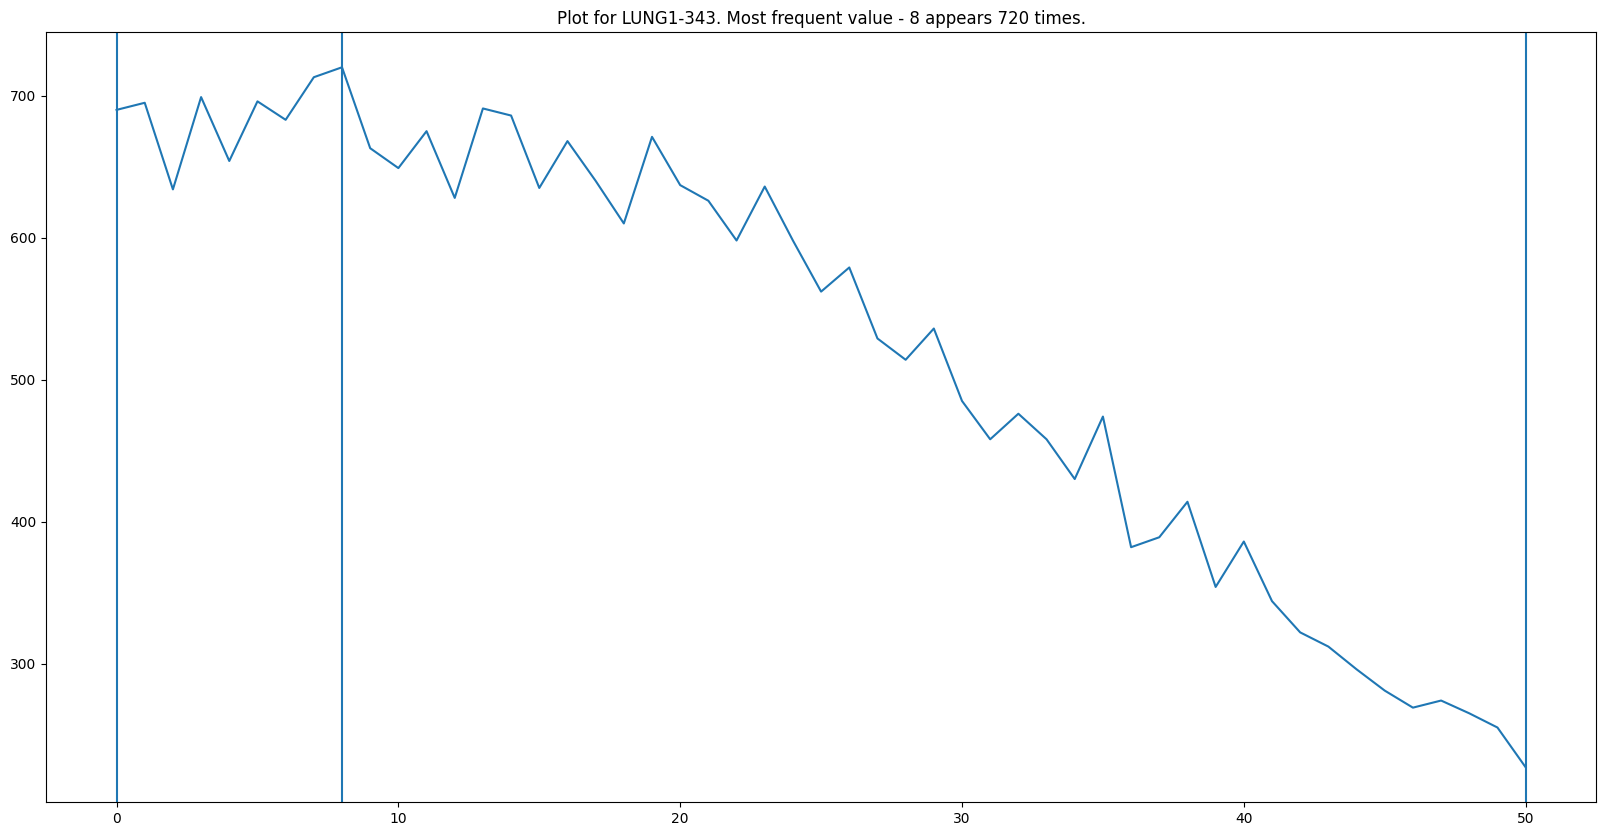

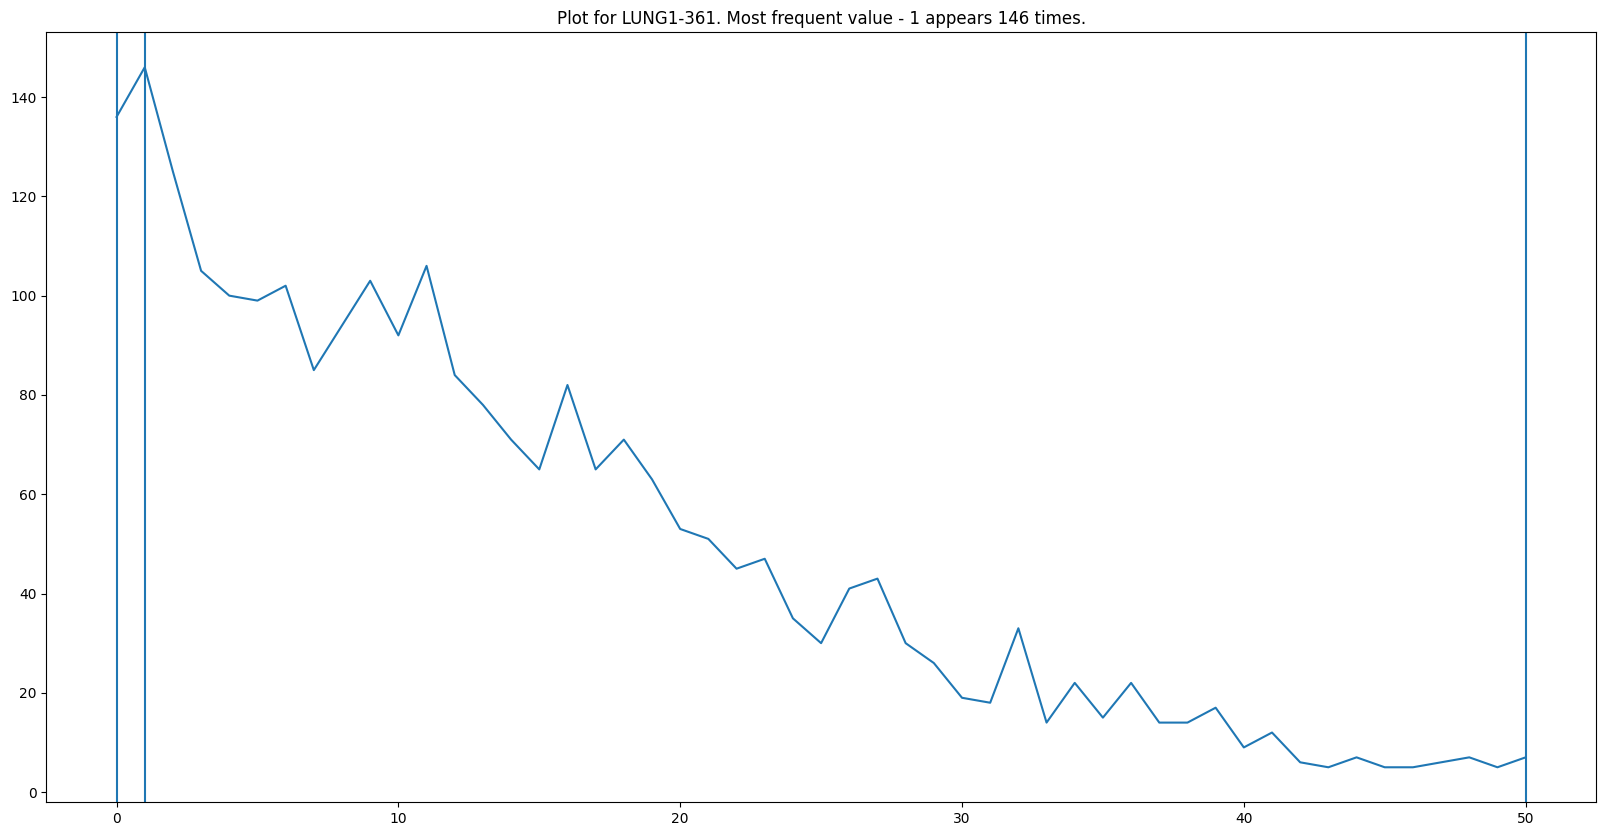

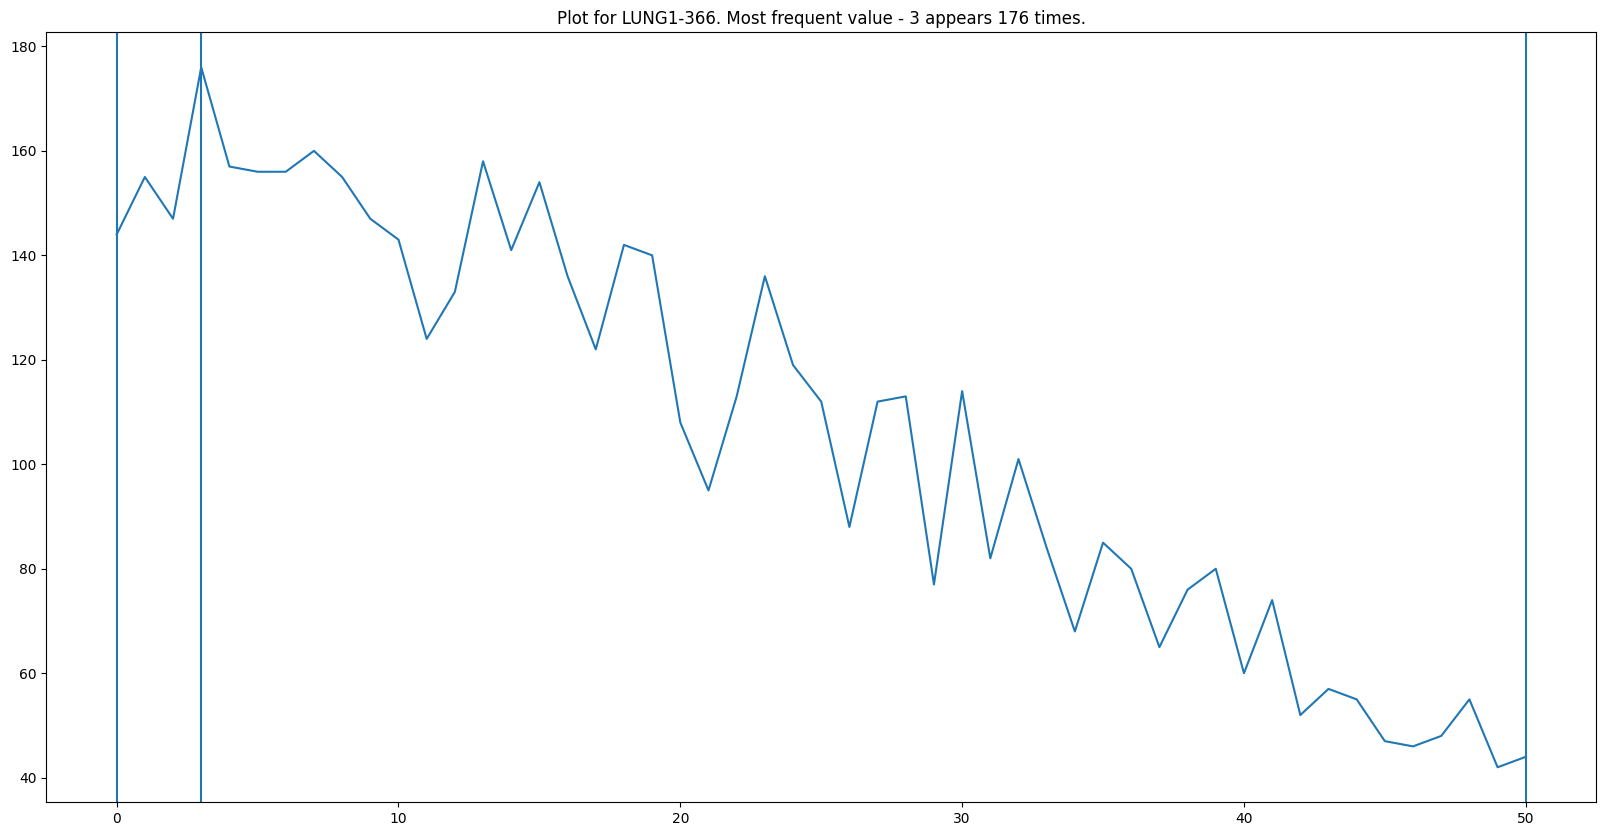

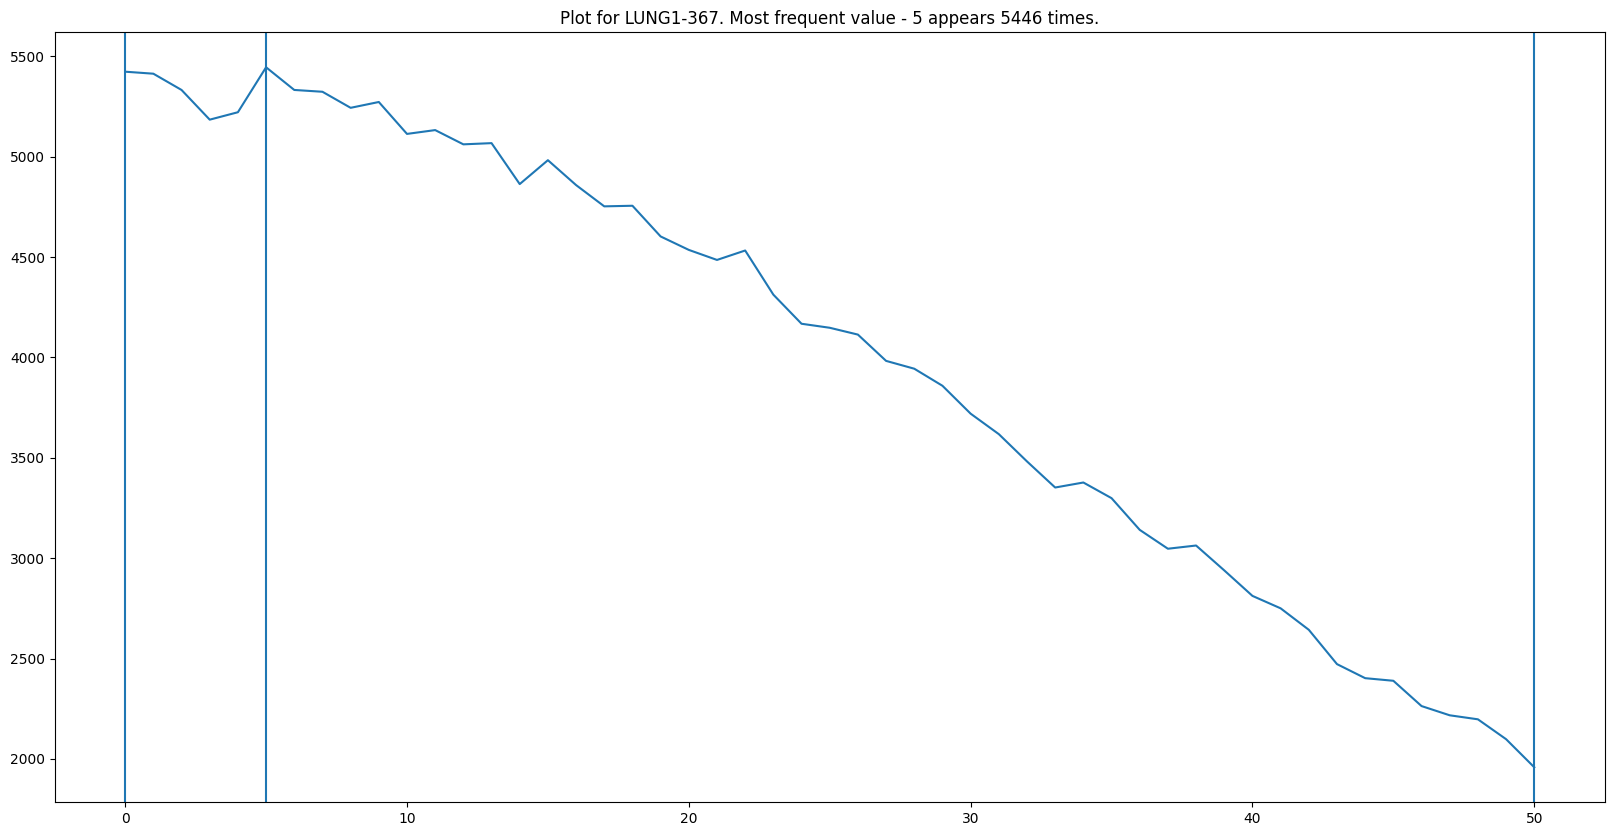

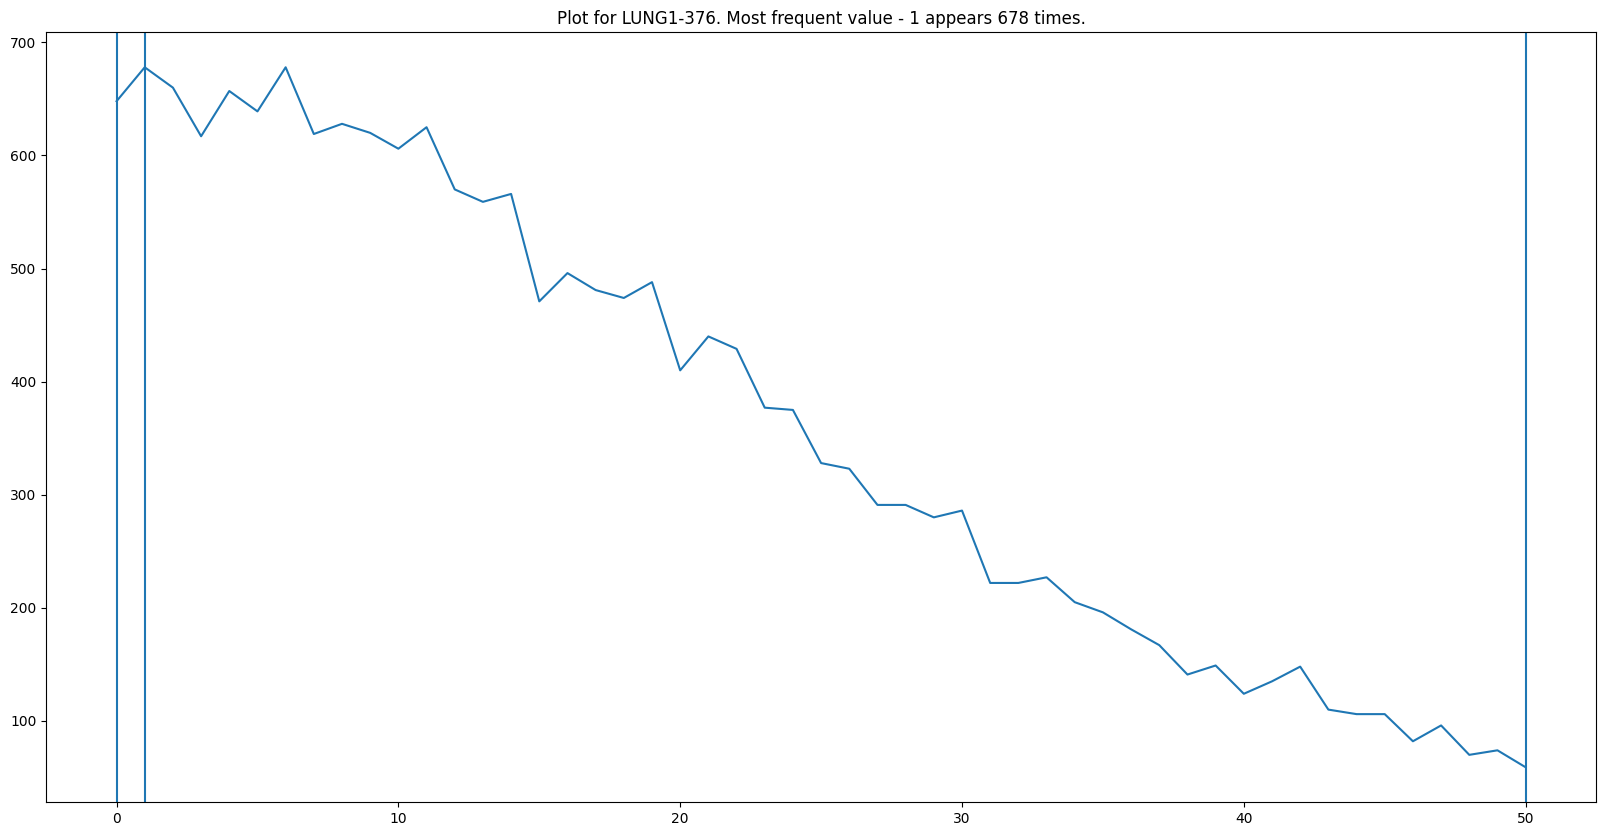

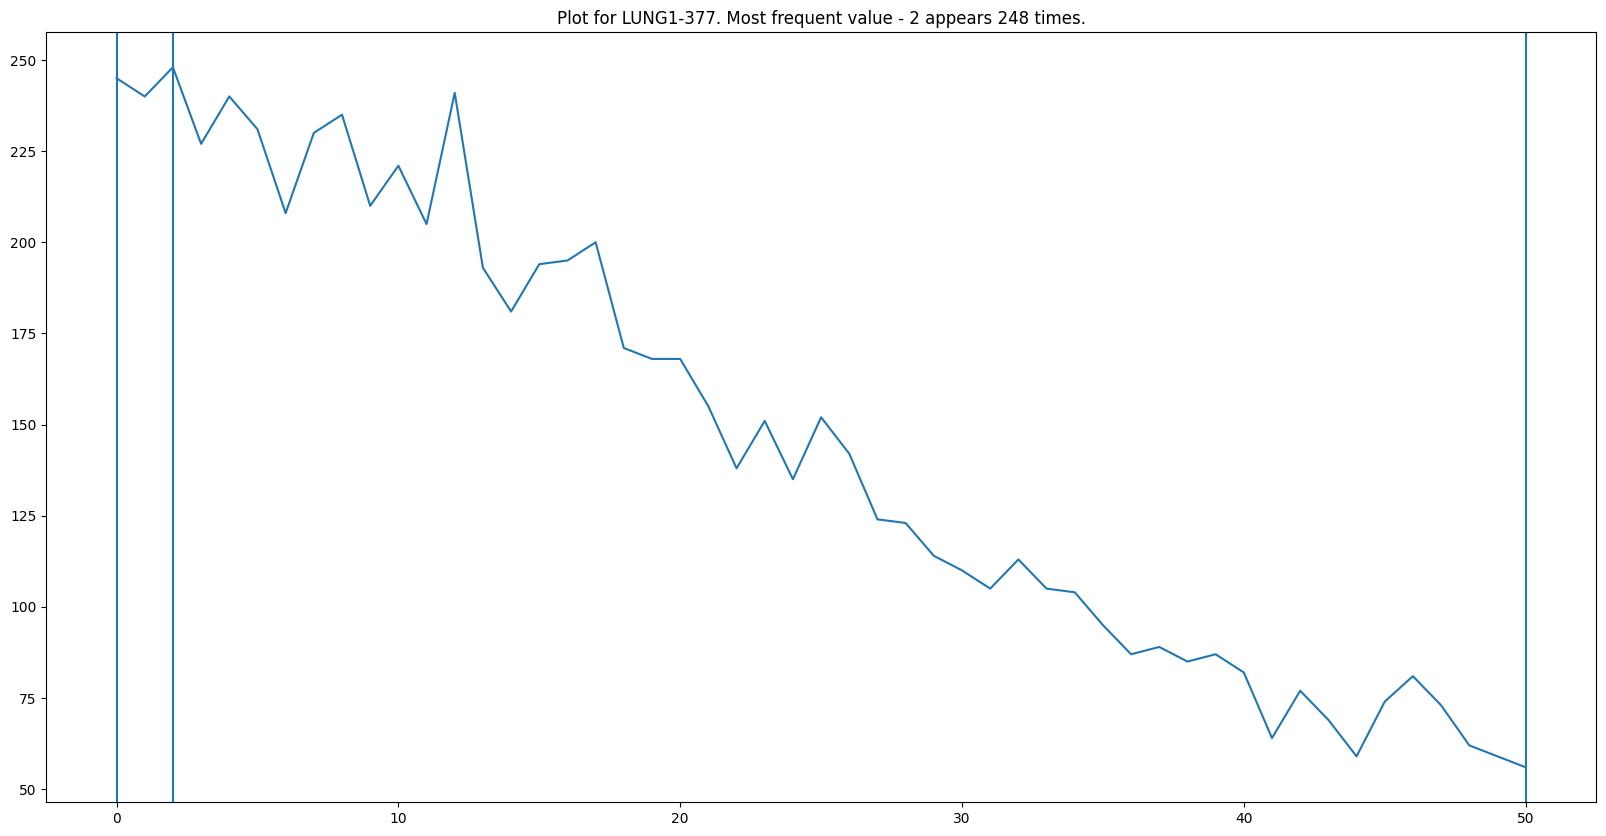

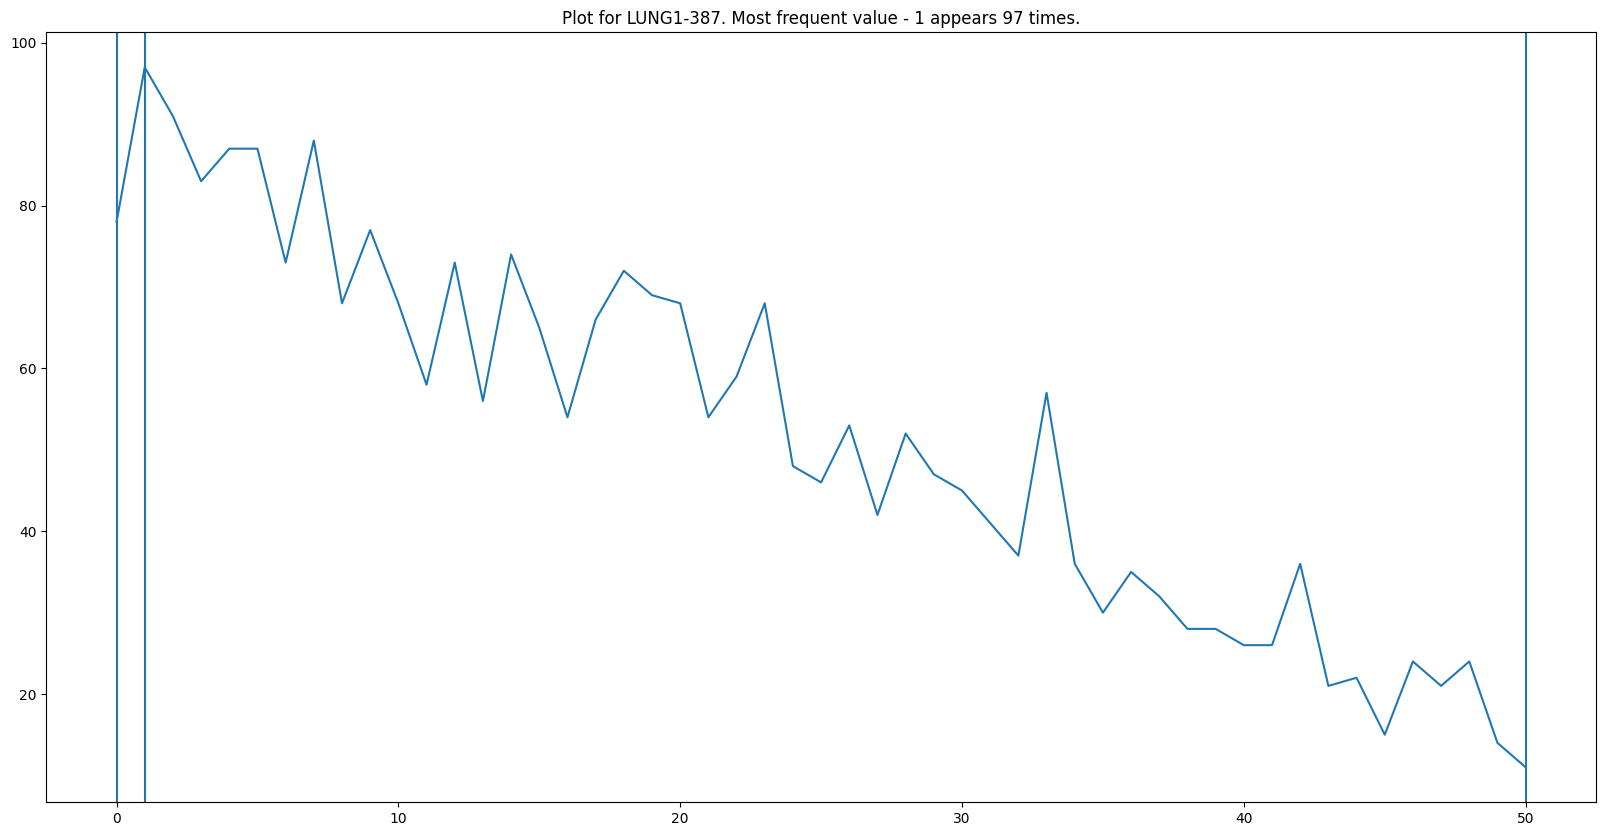

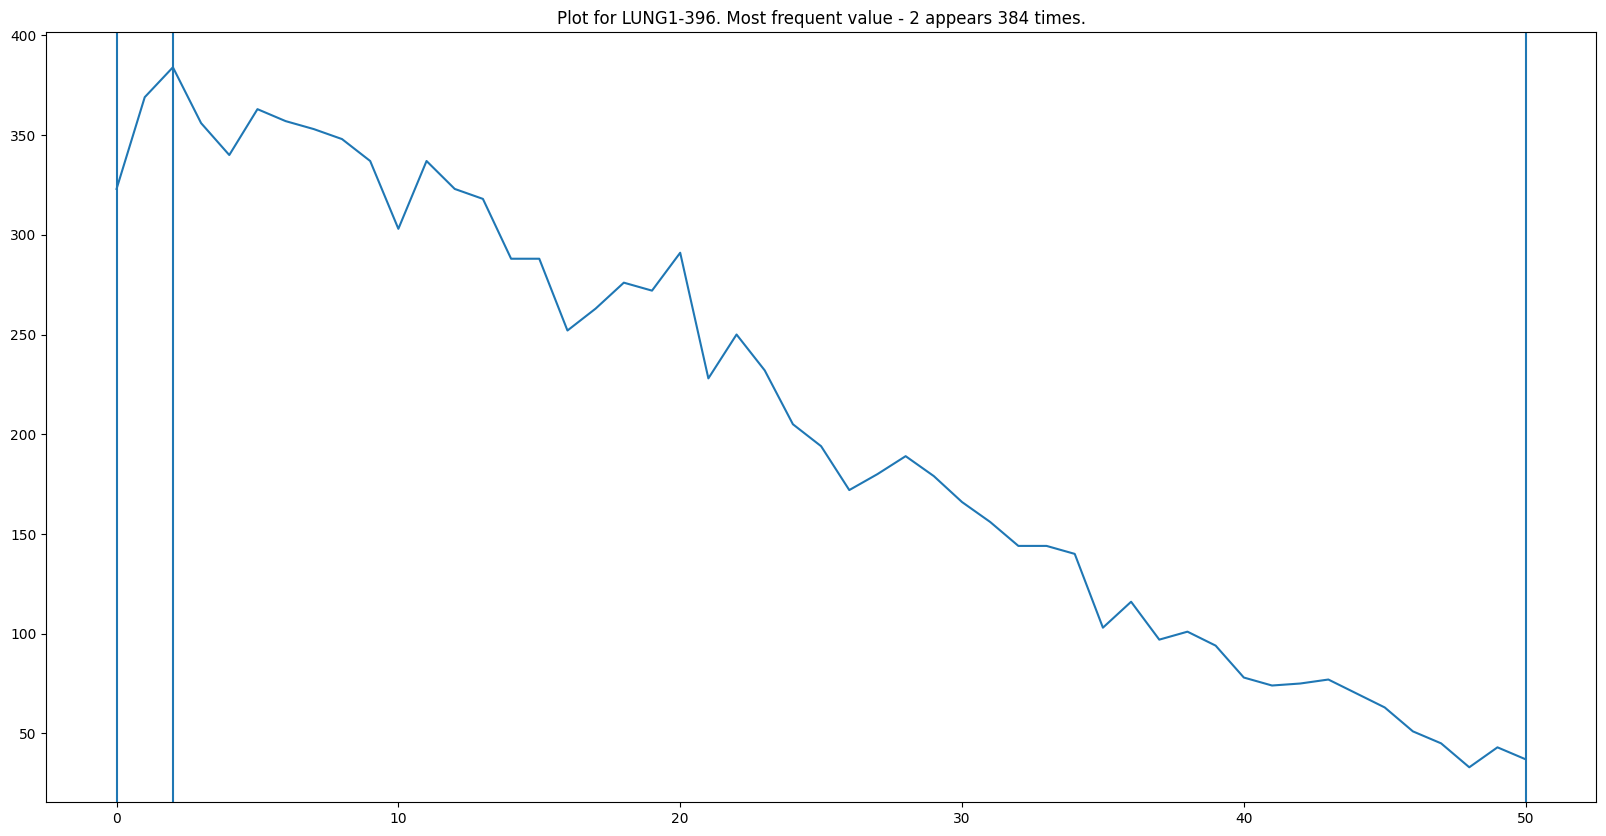

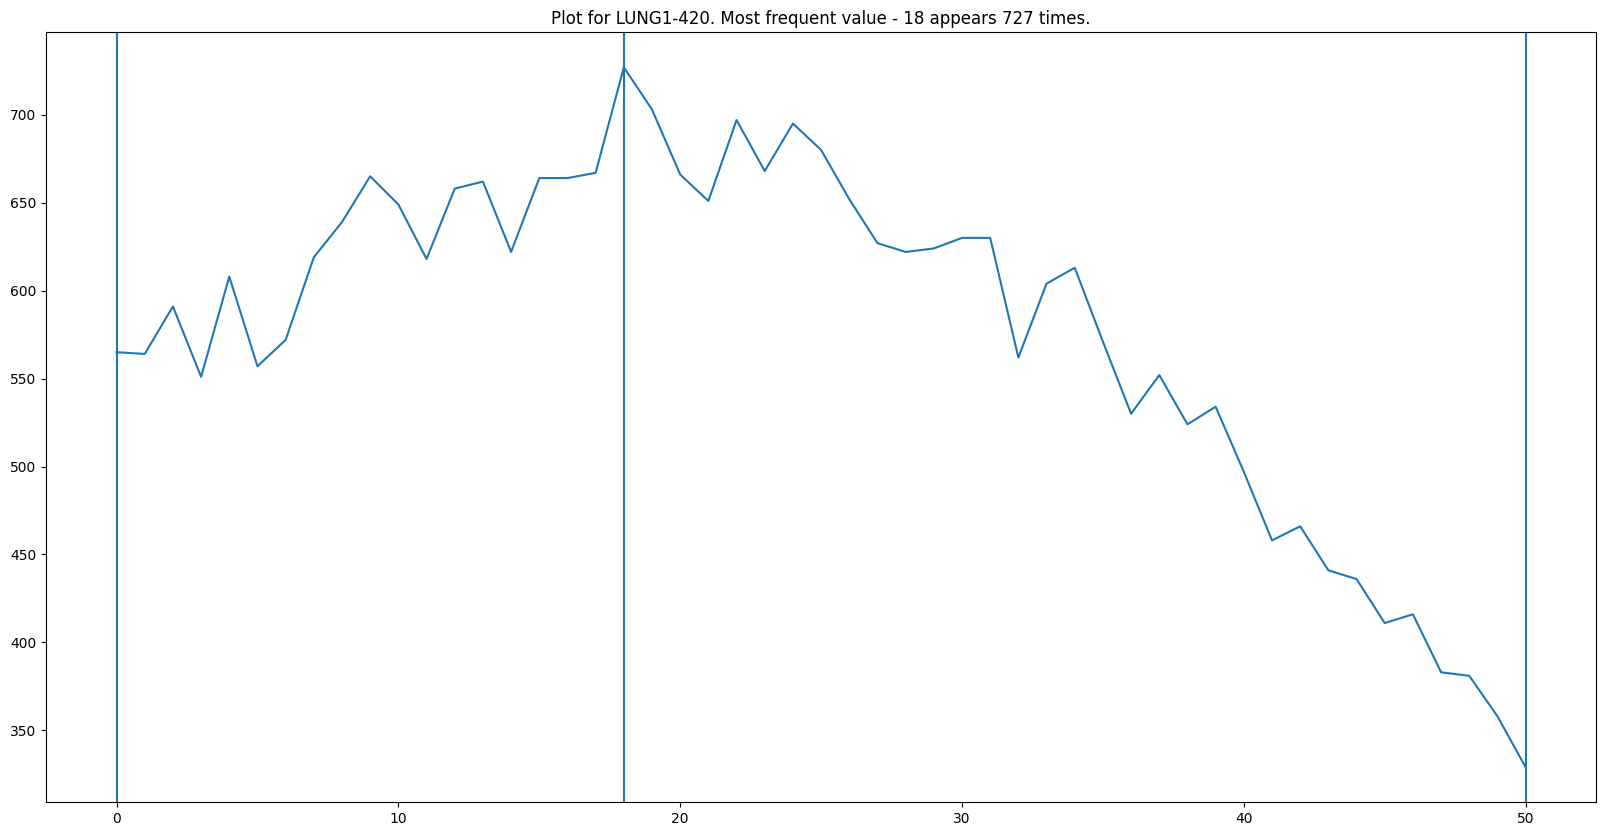

In [24]:
analyze_data(df)